# Circuit analysis for mechanistic interpretability: encoder models

In this chapter, we implement and demonstrate some tools for analyzing activations in encoder transformer models. Already existing tools (such as TransformerLens and Neuronpedia) are most adapted to decoder models that predict the next tokens (such as GPT 2). Thus, it might be interesting and useful to also develop tools that work for encoders that output text embeddings. 

More specifically, we implement ablation, activation patching and path patching, and we use various visualization techniques to get an overview of the effect of these interventions, as well as an overview of how information flows through the transformer. These tools are useful if a candidate circuit has been found, and one wishes to analyze specific nodes in it to find out if, and by how much, the various nodes contribute to an output. Path patching might also be useful to analyze how information flows between the nodes in a circuit. The example dataset that will be used to demonstrate the techniques is a set of mathematics questions and answers, and also some physics questions and answers from the Force Concept Inventory (FCI). 

We start by importing various libraries and initializing the model. We will use the multi-qa-MiniLM-L6-cos-v1 sentence-transformers model from Hugging Face. This is a relatively simple model (with roguhly 22.7 million parameters) that was developed for asymmetric semantic search; in particular, it was trained on comparing roughly 215 million question-answer pairs ([source](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1#multi-qa-minilm-l6-cos-v1)). Thus, this model is well equipped for many of our purposes, as we will be interested in comparing the semantic embedding vectors of the questions and answers in our dataset. 

In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import json 
import math
from types import MethodType
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
from typing import Optional
import math
import seaborn as sns

# initialize a tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1", trust_remote_code = True, use_fast = False)

#jinaai/jina-embeddings-v2-base-en
#sentence-transformers/all-MiniLM-L6-v2
#sentence-transformers/all-mpnet-base-v2
#deepset/bert-base-cased-squad2

#initialize the model
model = AutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1", trust_remote_code = True)
model.eval()

# Use GPU if available; if not, use the CPU
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

#Various model parameters - the number of attention-MLP layers num_layers, the hidden dimension d_model of embeddings 
#in the residual stream, the number of attention heads num_heads in each attention block, and the dimension d_head of
#the embeddings in each attention block (after projection). 
num_layers = len(model.encoder.layer)
d_model = model.config.hidden_size
MLP_intermediate_size = model.config.intermediate_size
num_heads = model.config.num_attention_heads
d_head = d_model // num_heads


Later in the program, we are going to modify the forward methods of attention blocks and attach hooks on MLP forward methods. For those purposes it will be important to be able to retrieve the original forward methods. We use the list handles to keep track of all handles to the hooks (so that we will be able to remove these hooks later), and the variable original_forward will contain the original forward method of the attention blocks. The point of defining these variables early in the program is that we wil be able to reuse them every time we modify the forward methods. 

In [2]:
original_forward = model.encoder.layer[1].attention.self.__class__.forward
handles = []

print(model.encoder.layer[5])

example_text = tokenizer("hei på deg, halla", return_tensors="pt")

embeddings = model(**example_text, output_hidden_states = True)

print(embeddings.last_hidden_state.shape)

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=384, out_features=384, bias=True)
      (key): Linear(in_features=384, out_features=384, bias=True)
      (value): Linear(in_features=384, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=384, out_features=384, bias=True)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=384, out_features=1536, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=1536, out_features=384, bias=True)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
torch.Size([1, 10, 384])


At the last layer of the transformer model, most sentence-transformers implement something called "pooling" (and then a final normalization of the embedding vector at the end) ([source](https://sbert.net/docs/sentence_transformer/usage/custom_models.html?utm_source=chatgpt.com)). The point of pooling is to condense the final embedding vectors of all tokens in the input text into a single, final embedding vector of the full text. multi-qa-MiniLM-L6-cos-v1 uses mean pooling, which means that we evaluate the average of all the final token embeddings. The two functions below are used to implement mean pooling for HuggingFace Transformers - these functions are heavily based on the functions "mean_pooling" and "encode" given in the [documentation](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1#multi-qa-minilm-l6-cos-v1) of the multi-qa-MiniLM-L6-cos-v1 model.

In [3]:

def mean_pooling(token_embeddings, attention_mask):
    '''
    Implements the mean pooling method to compute the final embedding vector from the final embedding vectors of the tokens. 
    Taken from the mean_pooling method in the Hugging Face documentation of the multi-qa-MiniLM-L6-cos-v1 model. 

    Arguments: 
        token_embeddings
            tensor which contains the last hidden state, ie. the final embeddings of all the tokens. Shape: (batch_size, seq_len, d_model)
        attention_mask
            used to ignore "fake" tokens that come from padding
    '''
                                     #token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
 


def embed(model, input_tokens):      #(text, model, tokens)
    """
    Performs a forward pass on the input tokens using the model, including the final mean pooling and normalization. 
    The function returns the final embedding vector of the input text. Mostly taken from the encode method in the 
    Hugging Face documentation of the multi-qa-MiniLM-L6-cos-v1 model. 

    Arguments: 
        model
            the transformer model used
        input_tokens 
            the tokens in the input text
    """

    #Compute token embeddings
    with torch.no_grad(): 
        model_output = model(**input_tokens,output_attentions=True)
 
    # Perform pooling and normalize
    embedding = mean_pooling(model_output[0], input_tokens['attention_mask'])
    return F.normalize(embedding, p=2, dim=1)

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: False
CUDA device count: 0


## Presenting the dataset: questions and answers

Next, we will read the files with the questions and answers. The file test.tok.json contains roughly 250 mathematical questions and answers, whereas FCI.json contains four of the questions, correct answers as well as wrong answer options from the Force Concept Inventory. This inventory contains various physics question-answer pairs, together with wrong answer options. 

The function read_file reads the files and puts the questions, answers (and potentially wrong_answers in the case of the FCI.json file) in the lists "questions", "answers" (and "wrong_answers"), respectively. 

In [5]:
def read_file(file): 
    """
    Reads a json file with questions and answers and returns lists with the questions, correct answers 
    (and potentially wrong answers). Each line in the json file should contain a dictionary with information about a question-answer pair; 
    the "questions" key gives the question, the "rationale" key gives the correct answer (or rationale), and the  "wrong i" key gives 
    the i-th wrong answer option. 
    """
    with open(file,"r") as infile: 
        infile.readline()
        lines = infile.readlines()

    #strip unwanted punctuation at the end of the dictionary at each line in the file 
    data = [json.loads(line.strip("\n").rstrip(',').rstrip("]")) for line in lines] 

    questions = [line["question"] for line in data]   #questions 
    answers = [line["rationale"] for line in data]     #correct answers

    #register wrong answer options in the wrong_answers dictionary (in the case when the file contains wrong answers) 
    wrong_answers = {}
    for i in range(len(data)):  
            for j in range(4): 
                if "wrong " + str(j+1) in data[i]:
                    wrong_answers[f"{j}.{i}"] = data[i]["wrong " + str(j+1)]

    return questions, answers, wrong_answers

#we read the two files and fill the questions and answers in their respective lists. 
questions, answers, wrong_answers = read_file("test.tok.json")
physics_questions, physics_answers, wrong_physics_answers = read_file("FCI.json")

Next we embed the questions and answers by doing a forward pass on the model. 

In [6]:
embedding_physics_Q = embed(model,tokenizer(physics_questions, padding=True, truncation=True, return_tensors='pt'))
embedding_physics_A = embed(model,tokenizer(physics_answers, padding=True, truncation=True, return_tensors='pt'))
embedding_Q = embed(model,tokenizer(questions, padding=True, truncation=True, return_tensors='pt'))
embedding_A = embed(model,tokenizer(answers, padding=True, truncation=True, return_tensors='pt'))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In order to get a sense of the relationship between the text embeddings of the questions and answers, we will visualize the embeddings using a t-SNE analysis. The methods used are based on the documentation [here](https://plotly.com/python/t-sne-and-umap-projections/). We visualize fifty of the question-answer pairs in the mathematics dataset. Each question and corresponding answer have the same color in the visualization, so that we can see the relation between them. 

In [7]:


def tSNEvisualization(embeddings, color_names, hover_names): 
    """
    Performs a t-SNE analysis with two dimensions and visualizes the results. 

    Arguments: 
        embeddings 
            a tensor or list with the embedding vectors that should be visualized 
        color_names 
            a list with the color names of all the embedding vectors
        hover_names 
            a list with the names of all embedding vectors when you hover over them
    """

    tsne = TSNE(n_components=2, random_state=30)
    #perplexity=30, random_state=42, learning_rate="auto", early_exaggeration=5.0, n_iter=5000, init="pca"
    tSNE_embeddings = tsne.fit_transform(embeddings.numpy())

    x = [x for x, y in tSNE_embeddings]
    y = [y for x, y in tSNE_embeddings]

    fig = px.scatter(
        tSNE_embeddings, x=0, y=1,
        width=700, height=700,
        color = color_names,
        hover_name=hover_names,
    )
    fig.update_layout(
        xaxis_title = "dim1", 
        yaxis_title = "dim2"   
    )
    
    fig.update_traces(
    hovertemplate=None,
    )
    
    fig.show()

embeddings = torch.cat([embedding_Q[::5],embedding_A[::5]],dim=0)
color_names = [i for i in range(len(embedding_Q[::5]))]*2
hover_names = ["question " + str(i) for i in range(len(embedding_Q[::5]))] + ["answer " + str(i) for i in range(len(embedding_A[::5]))]

tSNEvisualization(embeddings, color_names, hover_names)

Although it may be a bit difficult to see due to the similarity of the colors, the plot clearly shows that most question-answer pairs are very close. Since t-SNE generically preserves local neighborhoods ([source](https://opentsne.readthedocs.io/en/stable/tsne_algorithm.html)), this clearly indicates that the model does indeed cluster together a question and its corresponding answer. We would expect this, as the model used was trained to embed texts with similar semantic meaning close to each other. 

In order to quantify how many question-answer pairs are close to each other in semantic space, we can find the percentage of questions whose answers are among the k nearest neighbors (for some integer k). That is what the function below does for us. 

In [8]:
def closest_neighbors(embedding_Q,embedding_A,k): 
    '''
    Finds the percentage of question-answer pairs whose questions contain their corresponding answers 
    among the k nearest neighbors from the dataset of questions and answers. 
    The distance between questions and answers are computed using the L2 norm (though one would get the same result 
    if one used cosine distance). 

    Arguments: 
        embedding_Q 
            embedding vectors of the questions. 
        embedding_A 
            embedding vectors of the answers
        k 
            the number of neighbors checked. 
    '''

    # counts the number of question-answer pairs that are within the k nearest neighbors
    answer_is_near = 0

    #concatenate questions and answers into one dataset
    embedding = torch.cat([embedding_Q,embedding_A],dim=0)  

    #go through the questions and checks if answer is within k nearest neighbors; if yes, add 1 to answer_is_near
    for i in range(len(embedding_Q)): 
        distances, indices = torch.topk(-torch.norm(embedding[i] - embedding,dim=1),k)
        if torch.isin(i+len(embedding_Q),indices): 
            answer_is_near += 1

    return answer_is_near/len(embedding_Q)

print(closest_neighbors(embedding_Q[::5],embedding_A[::5],2))

0.8235294117647058


We see that 82 % of fifty of the question-answer pairs are contained within the nearest 2 neighbors. However, since a question is obviously a neighbor to itself, this shows that 82 % of the questions have their corresponding answer as the nearest neighbor (apart from itself). This shows that indeed, the model rather effectively clusters questions and answers together. 

## Circuit Analysis Techniques 

Now that we have the model and dataset, we will finally begin to present our implementation of some circuit analysis techniques. The methods are primarily different types of interventions. Broadly speaking, an intervention refers to a modification of the activations in certain parts of our model. By analyzing how the output embedding vectors change as a result of the interventions, we can learn a lot about how the model computes its output, and how information flows through the model during a forward pass.  

In order to implement these techniques, we need tools to be able to patch and cache activations. To cache activations means to register the activations in certain components of a model, whereas patching activations refers to replacing activations in specific components during a forward pass. Thus, we "freeze" certain activations and analyze how the output changes. The transformers library contains functions that are useful for implementing these techniques. More specifically, it contains methods that allow us to change a forward method (ie. the method that is implemented during a forward pass through a certain component in the model) on attention blocks and MLPs, as well as methods that allow us to place hook functions on certain components (which are functions that will be passed right after a forward pass through the component). 

It is important to be able to retrieve original forward methods after we have modified them. We use the list "handles" to keep track of all handles to the hooks (so that we will be able to remove these hooks later). The variable "original_forward" will contain the original forward method of the attention blocks. The point of defining these variables early on is that we wil be able to reuse them every time we modify the forward methods.


In [9]:
# the layer index does not matter, as the method is the same in all layers
original_forward = model.encoder.layer[1].attention.self.__class__.forward 

handles = []

The activations are contained in PyTorch tensors. Hence, in order to cache and patch activations, we will need to be able to slice and patch values into a tensor. In general, it is a little cumbersome to do this. Thus, we find it useful to define a function that does it for us, so that we can refer back to it whenever we need to slice or patch. 

In [10]:
def slice_or_patch(old_tensor, indices, new_values = None):
    '''
    slices or patches a PyTorch tensor. The function takes a PyTorch tensor old_tensor as input and does either 
    of two things: 
        
        1: new_values = None. In this case, the function returns a smaller tensor with elements retrieved from old_tensor by slicing
        at the indices specified in the list "indices". 

        2: new_values != None. In this case, the function returns a new tensor that is equal to old_tensor, except that the elements 
        at the indices in the list "indices" are replaced by the elements in the tensor new_values.
    '''
    # if an element in "indices" is slice(None), we set the corresponding element equal to 
    # a tensor containing all indices in old_tensor along the desired dimension. If a certain element 
    # in "indices" contains a list of indices, we turn it into a PyTorch tensor. This allows us to implement
    # torch.meshgrid on the list. 
    for i in range(len(indices)): 
        if isinstance(indices[i], slice):
            indices[i] = torch.arange(old_tensor.shape[i])
        if isinstance(indices[i], list): 
            indices[i] = torch.tensor(indices[i])

    # torch.meshgrid() must be used so that we can properly slice the tensor old_tensor. It gives grids of indices 
    # with the same dimension as old_tensor
    index_grids = torch.meshgrid(*indices, indexing="ij")

    if new_values is None: 
        return old_tensor[index_grids]
    else: 
        old_tensor[index_grids] = new_values
        return old_tensor

Now we introduce the function that allows us to cache and patch activations in attention heads. Part of the trouble with the transformers library is that it is not well adapted to access attention head activations. As far as I am aware of, there are no methods that allow us to directly cache these activations. However, this is what we can do instead: when we print model.encoder, we notice that for the multi-qa-MiniLM-L6-cos-v1 model that we use, each attention block performs a BertSdpaSelfAttention.forward() method during the attention.self part of the model. We can manually modify the forward method to access the attention head activations that are computed in the BertSdpaSelfAttention.forward() method. That is the idea behind the implementation below. 

The code implementing this method shows that BertSelfAttention.forward() is used instead when output_attentions = True (which we we used in the embed function above). This method utilizes a method called Scaled Dot Product Attention (SDPA), which makes caching and patching attention head activations more cumbersome. The easy way out was therefore to use BertSelfAttention.forward(). If output_attentions = False, then the forward method under the cache_and_patch_attn_head_activations function shown below would have to be modified. See the open source code [here](https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py) and documentation [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) for information about BertSdpaSelfAttention and the SDPA method. The essential point is that one would have to modify the SDPA method in order to cache and patch attention head outputs during the run of the SDPA alogrithm. 

The BertSelfAttention.forward() method that we have adopted in the function below can be found [here](https://huggingface.co/transformers/v2.1.1/_modules/transformers/modeling_bert.html?utm_source=chatgpt.com). 


For both attention head and MLP activations, we use dictionaries to contain the cached activations and the new activations we wish to patch. A given key in these dictionaries have the form (layer_idx, node_type), where layer_idx is the index of the layer and node_type is the type of the component/node at which we cache and/or patch activations. node_type can either take the value "MLP" or "attn" (for attention block). The value mapped to by this key is the corresponding tensor of activations. 

We can patch in new activations by either specifying the new activations to be patched in, or by specifying a number by which the old activations should be multiplied. The latter case will be useful for our implementation of ablation, and the former will be useful for activation and path patching. 


In [11]:
def cache_and_patch_attn_head_activations(layer_idx,attn_head_output = None,head_idx = slice(None),tokens = slice(None), patch_head_activation = None,alpha = None):
    '''
    caches and/or patches attention head activations. The function modifies the BertSelfAttention.forward() method by
    including a section where we cache the activations and put them in the attn_head_output dictionary, and/or where we modify 
    the attention head activations. Attention head activations can be modified in two ways - either by specifying a numerical factor alpha that the activations
    should be multiplied by, or by patching new activations into the old ones. In the latter case, the new activations are patched from the patch_head_activation
    tensor. 

    Arguments: 
        layer_idx
            the transformer layer at which we cache and/or patch. 
        attn_head_output
            dictionary which is filled with the cached activations. For a given layer layer_idx, the attention head activations 
            are set as the values mapped to by the key (layer_idx, "attn"). 
        head_idx
            list containing the indices of the attention heads whose activations should be either cached or patched. 
        tokens 
            list containing the indices of the tokens whose activations should be either cached or patched. 
        patched_head_activation 
            tensor containing the new activations that should be patched into the attention head activations. 
        alpha 
            float number that gives the factor that the attention head activations should be multiplied by. If this parameter 
            is specified, then it overwrites the patching.
    '''

    # Modified forward method. Most of the method is taken from BertSelfAttention.forward()
    def forward(self, hidden_states, attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[tuple[tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False) -> tuple[torch.Tensor]:
        
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores/math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = F.softmax(attention_scores,dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        #Here we cache activations if attn_head_output has been specified. 
        if attn_head_output is not None: 
            attn_head_output[(layer_idx, "attn")] = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)])                                           #context_layer.clone()    # shape: (batch_size, attention_head, seq_len, attn_dim)     attn_head_output[layer_idx] = context_layer.clone().detach()

        '''
        if tokens != slice(None): 
            updated_head_idx, updated_tokens = torch.meshgrid(torch.tensor(head_idx), torch.tensor(tokens), indexing='ij')
        else: 
            updated_head_idx, updated_tokens = head_idx, tokens
        '''

        # Here the modify attention head activations. If alpha is specified, we multiply old activations with this value; 
        # otherwise, if patch_head_activation has been specified, we patch its elements into the attention head activations. 
        if alpha is not None: 
            new_activations = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)]) * alpha
            context_layer = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)],new_activations)                                                         #orig_output[:,updated_tokens,updated_neuron_idx] *= alpha 
        else: 
            if patch_head_activation is not None: 
                context_layer = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)],patch_head_activation)

        '''
        if alpha is not None: 
            context_layer[:,updated_head_idx,updated_tokens,:] *= alpha
        else: 
            if (patch_head_activation is not None) and (head_idx is not None): 
                context_layer[:,updated_head_idx,updated_tokens,:] = patch_head_activation
        '''
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs)

        return outputs
    
    #Here, we substiute our new forward method. 
    model.encoder.layer[layer_idx].attention.self.forward = MethodType(forward, model.encoder.layer[layer_idx].attention.self)

Next, we implement the function that can be used to cache and patch MLP activations. We create a hook function for the MLPs that works similar to the forward function above; namely, it can be used to either cache MLP activations in a dictionary, and/or to patch in new activations. In the case of MLPs, we can cache and patch the output activations of individual neurons. 

In [12]:
def cache_and_patch_MLP_activations(layer_idx, MLP_output = None, neuron_idx = slice(None), tokens=slice(None), patch_neuron_activation = None,alpha = None,final_output = False):
    '''
    caches and/or patches MLP neuron activations. We create a hook for the forward method of the MLP layer. In the hook function, we cache the activations and 
    put them in the MLP_output dictionary, and/or modify the MLP neuron activations. These activations can be modified in two ways - either by specifying a numerical factor alpha 
    that the activations should be multiplied by, or by patching new activations into the old ones. In the latter case, the new activations are patched from the patch_neuron_activation
    tensor. 

    Arguments: 
        layer_idx
            the transformer layer at which we cache and/or patch. 
        MLP_output
            dictionary which is filled with the cached activations. For a given layer layer_idx, the neuron activations 
            are set as the values mapped to by the key (layer_idx, "MLP"). 
        neuron_idx
            list containing the indices of the neurons whose activations should be either cached or patched. 
        tokens 
            list containing the indices of the tokens whose activations should be either cached or patched. 
        patched_neuron_activation 
            tensor containing the new activations that should be patched into the MLP neuron activations. 
        alpha 
            float number that gives the factor that the neuron activations should be multiplied by. If this parameter 
            is specified, then it overwrites the patching.
    '''

    # Here we define the hook function
    def hook(module, inp, out): 
        orig_output = out.clone()

        # Here we cache neuron activations if MLP_output has been specified. 
        if MLP_output is not None: 
            MLP_output[(layer_idx, "MLP")] = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx])                                           #orig_output      # MLP_output[layer_idx] = orig_output[:,:,:].detach()

        '''
        if tokens != slice(None): 
            updated_tokens, updated_neuron_idx = torch.meshgrid(torch.tensor(tokens), torch.tensor(neuron_idx), indexing='ij')
        else: 
            updated_tokens, updated_neuron_idx = tokens, neuron_idx
        '''

        # Here the modify MLP neuron activations. If alpha is specified, we multiply old activations with this value; 
        # otherwise, if patch_neuron_activation has been specified, we patch its elements into the neuron activations. 
        if alpha is not None: 
            new_activations = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx]) * alpha
            orig_output = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx],new_activations)                                                         #orig_output[:,updated_tokens,updated_neuron_idx] *= alpha 
        else: 
            if patch_neuron_activation is not None: 
                orig_output = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx],patch_neuron_activation)
                                                                                   #orig_output[:,updated_tokens,updated_neuron_idx] = patch_neuron_activation

        return orig_output
    
    # Handles to the hook functions are filled in the handles list. 
    global handles 
    if final_output == False: 
        handles.append(model.encoder.layer[layer_idx].intermediate.register_forward_hook(hook))
    else: 
        handles.append(model.encoder.layer[layer_idx].output.register_forward_hook(hook))


For later, it will be useful to define some other helping functions as well. These are given below. The function "cache_and_patch_activations" can be used to cache and patch in either case, whether we wish to cache/patch MLP neuron activations or attention head activations. We simply need to specify our desired node_type (which can take either the value "MLP" or "attn"). 

The function remove_handles_and_retrieve_original_forward() is our "garbage can" function. When this function is called, it clears the handles list; this removes all MLP hook functions. Moreover, the forward methods on all attention blocks are brought back to the original forward method. This function must be run every time we need to make new hook functions or forward methods that are in conflict with earlier ones. 

Lastly, we use the function cache_and_patch_on_many_nodes to be able to cache and/or patch on several nodes. The reason is that we want maximal flexibility in our ablation and activation patching functions; one should be able to specify any number of nodes, at any layers, any node type (MLP neurons or attention heads) and any node indices. The primary parameter in the function is "nodes". This is a dictionary which contains a key-value pair for every node whose activations one wishes to cache or patch. The key is a tuple of the form (layer_idx,node_type), which specifies the layer and node type ("MLP" or "attn") of the node at which one wishes to patch or cache. The value is a list containing the indices of the MLP neurons or attention heads. The function cache_and_patch_on_many_nodes also contains a list "tokens" as a parameter. The i-th element in this list contains a list or slice of the token positions at which one wishes to cache or patch the i-th node in the "nodes" dictionary (thus, the *order* of elements in the "tokens" list and "nodes" dictionary matter). 

In [13]:
def cache_and_patch_activations(node_type, layer_idx, output = None, node_idx = slice(None), tokens = slice(None), patch_activation = None,alpha = None,final_output = False): 
    '''
    caches and/or patches activations. The node_type specifies the desired node at which we wish to cache and/or patch. It can either 
    take the value "MLP" (for MLP neuron activations) or "attn" (for attention head activations).

    Arguments: 
        node_type 
            the type of the node whose activations should be cached or patched. Can be either "MLP" or "attn". 
        layer_idx
            the transformer layer at which we cache and/or patch
        output
            dictionary which is filled with the cached activations. For a node at the given layer layer_idx and type node_type, 
            the neuron or attention head activations are set as the values mapped to by the key (layer_idx, node_type). 
        node_idx
            list containing the indices of the nodes (neurons or attention heads) whose activations should be either cached or patched. 
        tokens 
            list containing the indices of the tokens whose activations should be either cached or patched. 
        patched_activation 
            tensor containing the new activations that should be patched into the old activations. 
        alpha 
            float number that gives the factor that the old activations should be multiplied by. If this parameter 
            is specified, then it overwrites the patching.
    '''

    #turn node_idx and tokens into a list if a single scalar value has been specified
    if not isinstance(node_idx,(list,slice)):
        node_idx = [node_idx]
    if not isinstance(tokens,(list,slice)):
        tokens = [tokens]

    if node_type == "MLP": 
        cache_and_patch_MLP_activations(layer_idx = layer_idx,MLP_output = output, neuron_idx = node_idx, tokens = tokens, patch_neuron_activation = patch_activation,alpha = alpha,final_output = final_output)
    if node_type == "attn": 
        cache_and_patch_attn_head_activations(layer_idx = layer_idx,attn_head_output = output, head_idx = node_idx, tokens = tokens, patch_head_activation = patch_activation,alpha = alpha)


def remove_handles_and_retrieve_original_forward(): 
    '''
    removes all handles to MLP hook functions and retrieves all forward methods on attention blocks to their
    original forward methods. 
    '''

    # clear handles
    global handles
    [handle.remove() for handle in handles]
    #handles = []
    handles.clear()

    # retrieve original forward methods
    for i in range(num_layers): 
        model.encoder.layer[i].attention.self.forward = MethodType(original_forward,model.encoder.layer[i].attention.self)

def cache_and_patch_on_many_nodes(nodes,new_activations = None,tokens = None,old_activations = None,alpha = None):    # nodes: {[layer,"MLP/attn"]: node_indices}
    '''
    caches and/or patches activations of several nodes. The function calls cache_and_patch_activations for every node specified 
    in the "nodes" dictionary. 

    Arguments: 
        nodes  
            dictionary containing information about every node whose activations one wishes to cache or patch. 
            Every key-value pair is of the form (layer_idx, node_type): node_indices, where layer_idx is the layer index, 
            node_type is the type of the node ("MLP" or "attn") and node_indices is a list with the indices of the neurons or 
            attention heads whose activations will be patched or cached. 
        new_activations 
            dictionary with the new activations to be patched for every node in the "nodes" dictionary. The key-value pairs 
            are of the form (layer_idx, node_type): activations. For a node at a given layer layer_idx and node type node_type, the activations tensor 
            provides the new activations to be patched in. 
        tokens 
            list with the token positions at which each node in the "nodes" dictionary should have its activations either cached or patched. Thus, the order 
            of elements in "tokens" and "nodes" must be consistent. 
        old_activations 
            dictionary which is filled with the cached activations. For a given node at the layer layer_idx and with type node_type, the neuron or attention 
            head activations are set as the values mapped to by the key (layer_idx, node_type). 
        alpha 
            float number that gives the factor that the old activations should be multiplied by. If this parameter 
            is specified, then it overwrites the patching.

    '''

    # make an empty tokens and new_activations list if they were not specified - these will be filled up 
    # in the loop below to fit the length of "nodes". 
    if tokens is None: 
        tokens = []
    if new_activations is None: 
        new_activations = {}

    # In the loop below, we register the layer index, node indices and node types in lists 
    # layers, node_indices and node_types, respectively, for every node in "nodes". 
    layers = []
    node_indices = []
    node_types = []
    for location, node in nodes.items(): 
        layers.append(location[0])
        node_indices.append(node)
        node_types.append(location[1])

        # if "tokens" has too few elements, we add slice(None) to it (which means that activations of 
        # all tokens will be either cached or patched for the corresponding node). 
        if len(node_types) > len(tokens): 
            tokens.append(slice(None))

        # likewise, we add None to new_activations if it does not contain the key of the given node (meaning 
        # that no activations will be patched in for this node)
        if not((location[0],location[1]) in new_activations): 
            new_activations[(location[0],location[1])] = None
        '''
        else:  
            if location[1] == "MLP": 
                new_activations[(location[0],"MLP")] = new_activations[(location[0],"MLP")][:,tokens[len(layers) - 1],node]   #len(layers) - 1 is the index of the location-node pair in the nodes dict
            if location[1] == "attn": 
                new_activations[(location[0],"attn")] = new_activations[(location[0],"attn")][:,node,tokens[len(layers) - 1],:]
        '''

    #we cache and patch activations for all nodes in "nodes". 
    for i in range(len(layers)): 
        cache_and_patch_activations(node_type = node_types[i], layer_idx = layers[i], output = old_activations, node_idx = node_indices[i], tokens = tokens[i], patch_activation = new_activations[(layers[i],node_types[i])],alpha = alpha)

### Ablation

Finally, we will introduce our first circuit analysis (or intervention) technique, namely ablation. By using the functions we defined above, the implementation is relatively simple. We implement all three types of ablation, namely zero ablation, mean ablation and resampling (or random) ablation. The three types of ablation are briefly explained in Neel Nanda's glossary ([source](https://www.neelnanda.io/mechanistic-interpretability/glossary)), and they are also described [here](https://www.alignmentforum.org/posts/JvZhhzycHu2Yd57RN/causal-scrubbing-a-method-for-rigorously-testing).  

Zero ablation is relatively easy to understand, and easy to implement. In this case, we simply set certain activations equal to zero. In addition to this, I expanded the functionality of zero ablation by allowing a more "soft" version; instead of always multiplying the old activations by zero (which would amount to the usual zero ablation), you can use the function below to multiply the old activations by any float number. This number is called "alpha" in the function. 

Mean and resampling ablation are less trivial to implement. The way I decided to do mean ablation, is that for a given node (MLP neurons or attention heads), the function calculates the average over all batches specified in the list "data". Then the activations (of all batches) for the given node is set equal to this average. Similarly, resampling ablation is implemented by shuffling the activations among the batches in "data". 

There are many ways to implement mean and resampling ablation. In my implementation, the averaging and reshuffling is done over all the batches in "data". This could be problematic if there is a large variability in the number of tokens in the different batches. The activations at the padded token positions are approximately zero. If the batches contain a lot of padded tokens, then this would have a huge effect. Moreover, to do a mean- or resampling ablation, one would have to use a "data" list containing many batches every time one calls the function. Instead of this, one could first find a large dataset and calculate the average and reshuffled activations beforehand. Then one could pass a single batch to the ablation function and use the average and shuffled activations from this larger dataset. Moreover, instead of averaging and reshuffling over entire batches, one could calculate averages and do a reshuffle over individual tokens. 

The dictionary "nodes" is used to specify the nodes we wish to ablate. This dictionary has the same form as in the cache_and_patch_on_many_nodes function; thus, one can ablate any MLP neurons and attention heads at any layer in the model. 

In [14]:
def ablate(nodes, data, tokens = None, ablation_type = "zero", alpha = 0.0):
    '''
    performs an ablation. The ablation is done for all the nodes specified in the "nodes" dictionary. The function can
    perform a zero, mean or resampling ablation. The function returns the embedding of the text batches in "data" after a forward pass 
    with the ablated activations. 

    Arguments: 
        nodes
            dictionary containing information about every node whose activations one wishes to ablate. 
            Every key-value pair is of the form (layer_idx, node_type): node_indices, where layer_idx is the layer index, 
            node_type is the type of the node ("MLP" or "attn") and node_indices is a list with the indices of the neurons or 
            attention heads whose activations will be ablated.  
        data 
            list with batches; thus, each element in the list should be a text one wishes to do a forward pass and ablation on. 
        tokens 
            list with the token positions at which each node in the "nodes" dictionary should have its activations ablated. Thus, the order 
            of elements in "tokens" and "nodes" must be consistent. This list is only relevant for zero ablation. 
        ablation_type 
            string that specifies the type of ablation. It should either take the value "zero", "mean" or "resampling". 
        alpha 
            float number that gives the factor that the old activations should be multiplied by. This is only relevant for the case of zero ablation. 
            Thus, one can use this value to do a "soft" version of zero ablation, where the activations are multiplied by a given number 
            that is not necessarily zero. 
    '''

    # zero ablation
    if ablation_type == "zero": 
        cache_and_patch_on_many_nodes(nodes,tokens = tokens, alpha = alpha)

    # mean or resampling ablation
    if ablation_type == "mean" or ablation_type == "resampling": 

        # we first cache the old activations of the specified nodes
        dataset_activations = {}
        cache_and_patch_on_many_nodes(nodes, old_activations = dataset_activations)
        embed(model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))
        remove_handles_and_retrieve_original_forward()

        if ablation_type == "mean": 
            mean_activations = {}

            # here we calculate the average activations over all batches and patch these averages into the activations
            # of the specified nodes 
            for node_location, activations in dataset_activations: 
                mean_activation = torch.mean(activations, dim = 0,keepdim = True)
                mean_activations[node_location] = mean_activation.expand([len(data)] + [-1]*(mean_activation.dim()-1))
            cache_and_patch_on_many_nodes(nodes, new_activations = mean_activations)
        else: 

            # here we reshuffle the activations of the various batches and patch them into the activations
            # of the unshuffled batches 
            resampled_activations = dataset_activations[torch.randperm(len(data))]
            cache_and_patch_on_many_nodes(nodes, new_activations = resampled_activations)

    #calculate the embedding with the ablated activations
    ablated_embedding = embed(model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()
    
    #if type == "mean": 
        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    #if type == "random": 
        #new_activation = np.random.normal(0.0,1.0)
    #if type != "zero" and type != "mean" and type != "random": 
        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    return ablated_embedding

### Activation patching 

Next, we implement activation patching. Once again, we use the "nodes" dictionary and "tokens" list to be able to patch the activations of any nodes at any desired token positions. The function also allows you to specify the desired original and corrupted prompts that you wish to use to perform the activation patching. The function outputs the L2 and cosine distance between the embeddings of the clean and corrupted prompt after the activation patching. Thus, if the distance after activation patching is significantly less than the bare distance (before activation patching), then it indicates that the patched activations were important for providing the difference in semantic meaning between the two prompts. This allows us to learn how the model finds and stores semantic meaning in texts, such as the meaning of an answer to a question. 

In [15]:
def activation_patch(clean_prompt, corr_prompt,nodes,tokens = None): 
    '''
    performs an activation patching from a clean prompt to a corrupted prompt. The function patches in the activations of the clean run
    to the corrupted run at the nodes specified in the "nodes" dictionary and the tokens specified in the "tokens" list. It returns 
    both the L2 and cosine distance between the embeddings of the clean and corrupted prompts (with its activations patched). 

    Arguments: 
        orig_prompt 
            a string with the clean text prompt 
        corr_prompt 
            a string with the corrupted text prompt
        nodes 
            dictionary containing information about every node whose activations one wishes to patch. 
            Every key-value pair is of the form (layer_idx, node_type): node_indices, where layer_idx is the layer index, 
            node_type is the type of the node ("MLP" or "attn") and node_indices is a list with the indices of the neurons or 
            attention heads whose activations will be patched.  
        tokens 
            list with the token positions at which each node in the "nodes" dictionary should have its activations patched. Thus, the order 
            of elements in "tokens" and "nodes" must be consistent. 
    '''

    # in order to be able to compare the activations from the two prompts, the two prompts must have equal numbers of tokens. 
    # in general, we use padding with maximal length to do this. 
    max_tokens = max(len(tokenizer(clean_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

    # cache the activations from the clean run
    orig_activations = {}
    cache_and_patch_on_many_nodes(nodes,tokens = tokens, old_activations = orig_activations)
    orig_embeddings = embed(model,tokenizer(clean_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    # patch in the activations to the corrupted run 
    cache_and_patch_on_many_nodes(nodes,tokens = tokens, new_activations = orig_activations)
    corr_embeddings = embed(model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    return orig_embeddings, corr_embeddings, 1 - F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)

### Path patching 

Finally, we implement path patching. We recall that the specific algorithm that was implemented is the three-step algorithm provided by Callum McDougall in the appendix of the [following notebook](https://colab.research.google.com/drive/15CJ1WAf8AWm6emI3t2nVfnO85-hxwyJU#scrollTo=-r68Jjw3Xxhw). 

In the implementation below, the "receiver" and "sender" nodes refer to the *output* activations of specific attention heads or MLP neurons in the model. The reason we implemented it this way was twofold: first, these activations actually pick out the specific contributions from individual MLP neurons or attention heads (which is what we want). Second, this choice makes it possible to utilize the functions we made above. In McDougall's implementation of path patching, and in the algorithm in the Interpretability in the Wild paper, the receiver node refers to the *input* to an attention head. Whether we modify the input or output to an attention head (or MLP neuron) should not be important for the interpretation of the results (as we find the contributions of the direct path from the sender to receiver either way). 

I also expanded the path patching algorithm slightly in order to add some more functionality. By specifying receiver_node = None, the receiver node is effectively set to equal the *last hidden state*, ie. the final token embeddings after the final layer and layernorm. With this setting, we can analyze the direct contribution (ie. the contribution that goes through the direct paths) of each individual node to the final embedding.

Moreover, while the usual path patching algorithm requires a specification of the clean and corrupt prompt, I also added the ability to manually alter the activations of the sender node (without the need for a corrupted prompt). One can either alter it by multiplying the old activations with alpha, or by manually specifying the activations with the new_sender_node_activation dictionary. With this functionality, one has more control with how the sender node activations are changed, unlike in the case where one has to specify an appropriate corrupt prompt. 

In [16]:
def path_patching(sender_node,clean_prompt, receiver_node = None, corr_prompt = None,new_sender_node_activation = None, alpha = None):     #sender_node, receiver_node. ([layer,"MLP/attn"]: node_indices)
    '''
    implements path patching, based on the algorithm by Callum McDougall (which is equivalent to the algorithm given in the 
    Interpretability in the Wild paper (Wang et al., 2022)). The function returns the final embedding vector of the clean prompt 
    before and after having performed the path patching. One can use the function to implement path patching in two ways: 
    
        1: perform a path patching with a clean and corrupt prompt. In this case, the activations in the sender node are cached from the
        corrupt prompt. 
        2: manually alter the activations in the sender node (without the use of a corrupt prompt). 
    
    Path patching works by systematically caching and patching the activations on the receiver and sender node, so
    that one finds how the output embedding of the clean prompt is affected by the contribution of the direct path from the sender to receiver 
    in the corrupted prompt (or the contribution of the direct path to alter the activations in the receiver node due to the manual change to the sender
    node activations). 

    The steps 1, 2 and 3 below refer to the steps of the path patching algorithm specified in the notebook by Callum McDougall. 

    Arguments: 
        sender_node 
            dictionary specifying the sender node. It consists of a single key-value pair of the form (layer_idx, node_type): node_indices, 
            where layer_idx is the layer index, node_type is the type of the node ("MLP" or "attn") and node_indices is a list with the indices of the neurons or 
            attention heads in the sender node.
        receiver_node 
            dictionary specifying the receiver node. It consists of a single key-value pair of the form (layer_idx, node_type): node_indices, 
            where layer_idx is the layer index, node_type is the type of the node ("MLP" or "attn") and node_indices is a list with the indices of the neurons or 
            attention heads in the receiver node. If receiver_node is None, then the receiver node is effectively set to equal the final mean pooling layer
            (ie. we do path patching from the sender node to the final output) 
        clean_prompt 
            a string with the clean text prompt 
        corr_prompt 
            a string with the corrupted text prompt
        new_sender_node_activation 
            dictionary containing key-value pairs with the new activations in the sender nodes (for case 2). 
            The key is the tuple (sender_node_layer_idx, sender_node_type) and the value is a tensor with the new activations. 
        alpha 
            float number that gives the factor that the old sender node activations should be multiplied by (for case 2). Thus, instead of using 
            new_sender_node_activation, one can use this number to alter the sender node activations. 
            
    '''

    if corr_prompt is not None: 
        max_tokens = max(len(tokenizer(clean_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))
    else: 
        max_tokens = len(tokenizer(clean_prompt)["input_ids"])


    '''
    sender_node_type = list(sender_node.values())[0]
    sender_location = [int(el) for el in list(sender_node.keys())[0].split(".")]
 
    receiver_node_type = list(receiver_node.values())[0]
    receiver_location = [int(el) for el in list(receiver_node.keys())[0].split(".")]
    '''

    #  ------ STEP 1 -----

    #Cache clean attention head activations
    clean_attn_heads = {}
    attn_head_nodes = {(i,"attn"): list(range(num_heads)) for i in range(num_layers)}

    cache_and_patch_on_many_nodes(attn_head_nodes,old_activations = clean_attn_heads)

    orig_embedding = embed(model,tokenizer(clean_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    #Cache corrupt receiver node activations (if the corrupt prompt has been specified)
    if corr_prompt is not None: 
        corr_sender_node_act = {}

        cache_and_patch_on_many_nodes(sender_node, old_activations = corr_sender_node_act)                                                      #cache_and_patch_activations(node_type = sender_node_type, layer_idx = sender_location[0],output = corr_sender_node_act)

        embed(model, tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
        remove_handles_and_retrieve_original_forward()
    
    # ------- STEP 2 ------

    if receiver_node is not None: 
        freezed_attn_head_nodes = dict(list(attn_head_nodes.items())[list(sender_node.keys())[0][0] + 1:list(receiver_node.keys())[0][0]])
    else: 
        freezed_attn_head_nodes = dict(list(attn_head_nodes.items())[list(sender_node.keys())[0][0] + 1:])

    #Patch clean attention head activations (ie. freeze these activations)
    cache_and_patch_on_many_nodes(freezed_attn_head_nodes,new_activations = clean_attn_heads)

    #Patch corrupt receiver node activations, or manually patch new sender node activations
    if corr_prompt is not None: 
        cache_and_patch_on_many_nodes(sender_node, new_activations = corr_sender_node_act)
    else: 
        cache_and_patch_on_many_nodes(sender_node, new_activations = new_sender_node_activation, alpha = alpha)

    # If the receiver node is not the final mean pooling layer, then do a forward pass on the clean prompt 
    # and cache the receiver node activations. If the receiver node is the final layer, then this 
    # part is not needed (since the output would be unchanged after patching cached final layer activations from a previous run)
    if receiver_node is not None: 
        receiver_node_act = {}
        cache_and_patch_on_many_nodes(receiver_node, old_activations = receiver_node_act)
        embed(model,tokenizer(clean_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
        remove_handles_and_retrieve_original_forward()

        # -------- STEP 3 ---------

        # Patch the cached receiver node activations 
        cache_and_patch_on_many_nodes(receiver_node, new_activations = receiver_node_act)

    # Final forward pass on the clean prompt with the patched receiver node activations
    new_embedding = embed(model,tokenizer(clean_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''

    for i in range(receiver_location[0]): 
        if i > sender_location[0]: 
            cache_and_patch_activations(node_type = "attn", layer_idx = i,node_idx = list(range(num_heads)),patch_activation = clean_attn_heads[i])

    if sender_node_type == "MLP": 
        patch_activation = corr_sender_node_act[0][:,:,sender_location[1]]
    if sender_node_type == "attn": 
        patch_activation = corr_sender_node_act[0][:,sender_location[1],:,:]

    

    cache_and_patch_MLP_activations(node_type = sender_node_type,layer_idx = sender_location[0],node_idx = sender_location[1], patch_activation = patch_activation)

    receiver_node_act = []

    cache_and_patch_activations(node_type = receiver_node_type, layer_idx = receiver_location[0],output = receiver_node_act)

    embed(model,tokenizer(orig_prompt, padding=True, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''

    '''
    if receiver_node_type == "MLP": 
        patch_activation = receiver_node_act[0][:,:,receiver_location[1]]
    if receiver_node_type == "attn": 
        patch_activation = receiver_node_act[0][:,receiver_location[1],:,:]

    cache_and_patch_activations(node_type = receiver_node_type, layer_idx = receiver_location[0],node_idx = receiver_location[1], patch_activation = patch_activation)

    new_embedding = embed(model,tokenizer(orig_prompt, padding=True, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''
    # orig_embedding: before path patching. new_embedding: after path patching. 
    return orig_embedding, new_embedding

## Examples of circuit analysis tools

We will now test our code that implements activation patching and ablation. For now, we just test it on random neurons and MLP layers to see whether the fraction of questions containing their answers as nearest neighbors have changed appreciably. 

In [ ]:

def visualize_attn_head_and_MLP_strengths(attn_head_values, MLP_values,title,label): 

    # Plotting attention head values for every layer

    fig1, ax1 = plt.subplots(figsize = (8, 6))
    sns.heatmap(attn_head_values, cmap='viridis', annot=True, fmt=".2g", annot_kws={"size": 8},
            xticklabels=[f"H{i}" for i in range(attn_head_values.shape[1])],
            yticklabels=[f"L{i}" for i in range(attn_head_values.shape[0])],
            cbar_kws={"label": "Activation Strength"})
    ax1.set_title(title + " attention heads")
    ax1.set_xlabel("Head")
    ax1.set_ylabel("Layer")
    fig1.tight_layout()
    plt.show()

    # Plotting MLP values for every layer
    fig2, ax2 = plt.subplots(figsize = (8, 6))
    sns.heatmap(MLP_values, cmap='viridis', annot=True, fmt=".2g", annot_kws={"size": 8},
            xticklabels=[f"N{i}" for i in range(MLP_values.shape[1])],
            yticklabels=[f"L{i}" for i in range(MLP_values.shape[0])],
            cbar_kws={"label": label})
    ax2.set_title(title + " MLP neurons")
    ax2.set_xlabel("MLP node")
    ax2.set_ylabel("Layer")
    fig2.tight_layout()
    plt.show()


def intervene_on_many_nodes(reference_prompt, prompt, title, label, corr_prompt = None, receiver_node = None, intervention_type = "ablation", tokens = None, ablation_type = "zero", new_node_activation = None, alpha = 0.0,num_MLP_neurons = 1): 

    reference_embedding = embed(model,tokenizer(reference_prompt, padding = True, truncation=True, return_tensors='pt'))
    orig_embedding = embed(model,tokenizer(prompt, padding = True, truncation=True, return_tensors='pt'))

    chunk_size = MLP_intermediate_size//num_MLP_neurons
    MLP_nodes = [list(range(chunk_size*i, chunk_size*(i+1))) for i in range(num_MLP_neurons)]
        
    MLP_values = np.zeros((num_layers,len(MLP_nodes)),float)
    attn_head_values = np.zeros((num_layers,num_heads),float)
    for i in range(num_layers): 
        for j in range(len(MLP_nodes)): 
            node = {(i,"MLP"): MLP_nodes[j]}
            if intervention_type == "ablation": 
                intervened_embedding = ablate(node,prompt,tokens = tokens, ablation_type = ablation_type, alpha = alpha)
            if intervention_type == "activation patching": 
                _, intervened_embedding, _, _ = activation_patch(reference_prompt, prompt,node, tokens = tokens)
            if intervention_type == "path patching": 
                _, intervened_embedding = path_patching(sender_node = node,clean_prompt = prompt, corr_prompt = corr_prompt, receiver_node = receiver_node, new_sender_node_activation = new_node_activation, alpha = alpha)
            distance_reference_intervened_prompt = 1 - F.cosine_similarity(reference_embedding[0], intervened_embedding[0],dim=0)
            distance_reference_orig_prompt = 1 - F.cosine_similarity(reference_embedding[0], orig_embedding[0],dim=0)
            MLP_values[i,j] = (distance_reference_orig_prompt - distance_reference_intervened_prompt)/distance_reference_orig_prompt

        for j in range(num_heads): 
            node = {(i,"attn"): j}
            if intervention_type == "ablation": 
                intervened_embedding = ablate(node,prompt,tokens = tokens, ablation_type = ablation_type, alpha = alpha)
            if intervention_type == "activation patching": 
                _, intervened_embedding, _, _ = activation_patch(reference_prompt, prompt,node, tokens = tokens)
            if intervention_type == "path patching": 
                _, intervened_embedding = path_patching(sender_node = node,clean_prompt = prompt, corr_prompt = corr_prompt, receiver_node = receiver_node, new_sender_node_activation = new_node_activation, alpha = alpha)
            distance_reference_intervened_prompt = 1 - F.cosine_similarity(reference_embedding[0], intervened_embedding[0],dim=0)
            distance_reference_orig_prompt = 1 - F.cosine_similarity(reference_embedding[0], orig_embedding[0],dim=0)
            attn_head_values[i,j] = (distance_reference_orig_prompt - distance_reference_intervened_prompt)/distance_reference_orig_prompt
    
    visualize_attn_head_and_MLP_strengths(attn_head_values, MLP_values,title=title,label=label)

def visualize_activations(title, text = None,tokens = slice(None),attn_head_act = None,MLP_act = None,num_MLP_neurons = 1): 
    
    if attn_head_act == None:
        attn_head_act = {}
        [cache_and_patch_attn_head_activations(i,attn_head_output = attn_head_act,tokens = tokens) for i in range(num_layers)]

    if MLP_act == None:
        MLP_act = {}
        [cache_and_patch_MLP_activations(i, MLP_output = MLP_act, tokens=tokens,final_output = False) for i in range(num_layers)]
    
    if text is not None: 
        embed(model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    
    ancilla_head_act = attn_head_act
    ancilla_MLP_act = MLP_act
    remove_handles_and_retrieve_original_forward()
    attn_head_act = torch.stack(list(attn_head_act.values()))
    print(attn_head_act.shape)
    MLP_act = torch.stack([torch.stack(torch.chunk(el,num_MLP_neurons,dim=-1)) for el in MLP_act.values()])
    print(MLP_act.shape)
    #MLP_act = torch.stack(list(MLP_act.values()))

    avg_attn_head_act = torch.norm(attn_head_act, p = 2,dim=-1).mean(dim=[1,3])
    avg_mlp_act = torch.norm(MLP_act, p = 2,dim=-1).mean(dim=[2,3])

    visualize_attn_head_and_MLP_strengths(avg_attn_head_act, avg_mlp_act,title = title,label="Normed activations")
    
    return ancilla_head_act, ancilla_MLP_act


With the visualization tools ready, we can demonstrate some simple examples. 

First, I wish to summarize some interesting findings. After trial and error visualizing activations, as well as performing ablation and activation patching, I found some interesting general trends. I will show some examples below. The main bullet points, however, are the following: 

- some words/concepts seem to fire the same attention head activations, *independent of their locations in the sentence*. Sometimes, a single word/concept fires a single attention head. For example, I attempted various physics answers and stumbled upon the fact that using the word "friction" in a sentence usually activated headh H7 in the last attention layer (layer 5). Other times, a single word activated several attention heads in the last attention layer. For instance, the word "gravity" activated both head H7 and head H4. However, the most striking example I stumbled upon was that of *color* - I found that almost all colors (whether it was represented by the words "green", "red", "blue" etc.) caused a strong activation in head H1! Thus, to use the terminology explained at the beginning of the notebook, it appears that this attention head responded strongly to the *feature* color. Since this attention head appears in the last layer, this could perhaps indicate that it might represent the last node in a circuit that is involved in representing the semantic meaning of text involving color. 
- Activation patching seemed to be really useful for highlighting such behavior in single words/concepts. In fact, I used activation patching to find the properties mentioned above in the first place. The reason is that with activation patching, you can control how you corrupt a sentence. For instance, you could create a corrupted sentence where only a single word has been substituted for another. While it often works to visualize the activations of the original prompt in order to find which attention heads or MLP neurons are most active, activation patching was more useful for extracting the source of these activations (as well as finding *exactly* which nodes the individual words/concept activate). 
- I found it more difficult to find meaningful results from ablation and path patching. Although it often was the case that the cosine distance between the question and answer changed appreciably when I ablated the most active attention heads of the answer, it was also often the case that the distance changed appreciably when I ablated other, less active attention heads. This could perhaps indicate that other heads had a bigger effect on the distance between the question and answer than the mere absolute activations would indicate. At the same time, it made it harder to extract meaningful results from the ablation experiments. 
- It was also hard to interpret the activations of the MLP neurons - those did not appear to be consistent for different placements of words/concepts in a sentence, or between the different types of interventions. This might be expected, as MLP neurons might process information about the detailed structures of a text and hence could be sensitive to the type of interventions on the activations of those texts. I did see one interesting result though, which was that for some (but nonetheless quite varied) text prompts, the MLP neurons at layer L3 with indices from 768 to 960 were most active. There were also often high activations in the neurons with the same indices, but at other MLP layers. The neurons at layer L3 with indices from 768 to 960 are almost at the very center of the network - perhaps this could indicate that these neurons act as "vessels" that soak in information from early layers and act as a source of information for later layers? In that case, they could be excellent nodes in a circuit that is ued to find more subtle structures in input sentences. Although there were a lot of sentences with high activations in these neurons, it was not the case for all sentences - this could indicate that there is some subtle similarity between sentences that have these activations. On the other hand, it could also be that the MLP neurons at the layer L3 do not have much meaning at all, and that they simply respond to generic text prompts. It would be interesting to investigate this further! 

I start by visualizing the activations from sentences with color words. As mentioned above, we see that for a variety of sentences, the head H1 at the layer L5 has the highest activations. Despite the huge variation in the strcture of the sentences, it appears that the activations of attention head H1 The color sentences are also examples of sentences that lead to high activations in the MLP neurons with indices between 768 and 960. The layer L3 has the neurons of highest activations, but the layers L1, L2 and L4 also activate strongly. 



['the', 'skies', 'here', 'are', 'so', 'blue']
['is', 'is', 'clearly', 'red']
['i', 'am', 'looking', 'at', 'the', 'yellow', 'flowers', 'over', 'there']
torch.Size([6, 1, 12, 8, 32])
torch.Size([6, 8, 1, 8, 192])


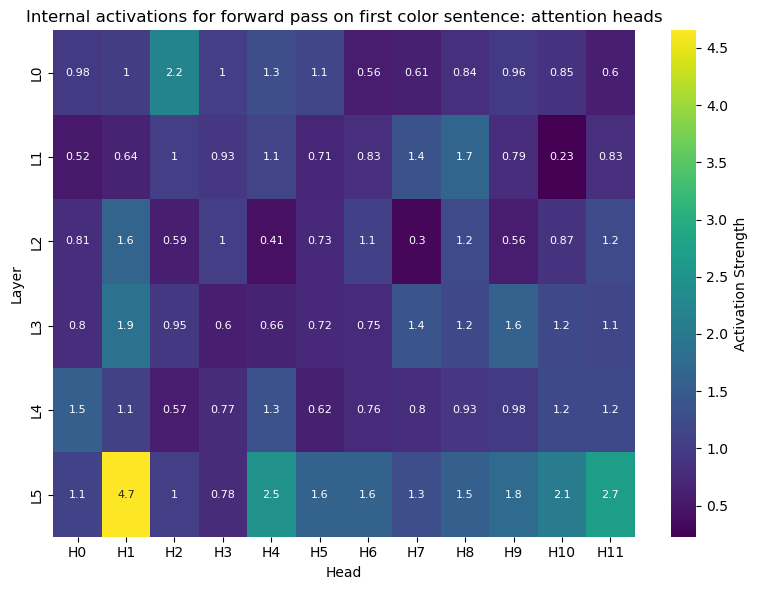

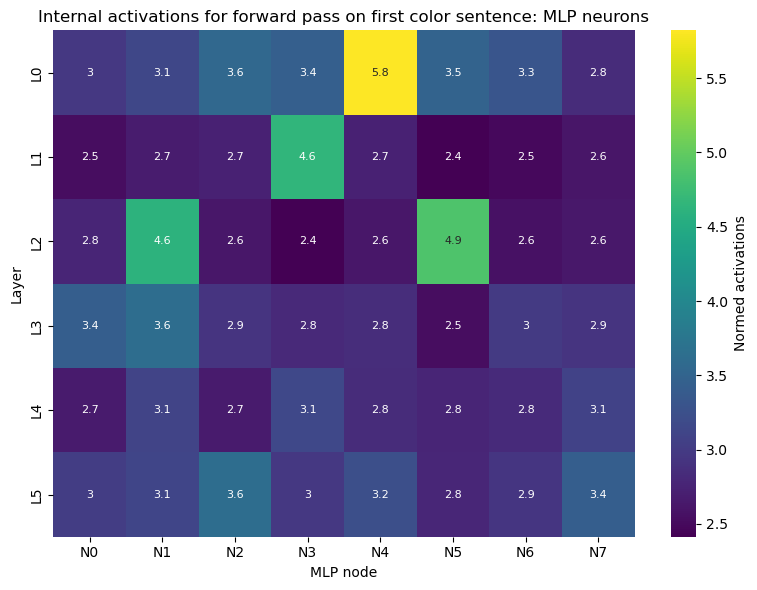

torch.Size([6, 1, 12, 6, 32])
torch.Size([6, 8, 1, 6, 192])


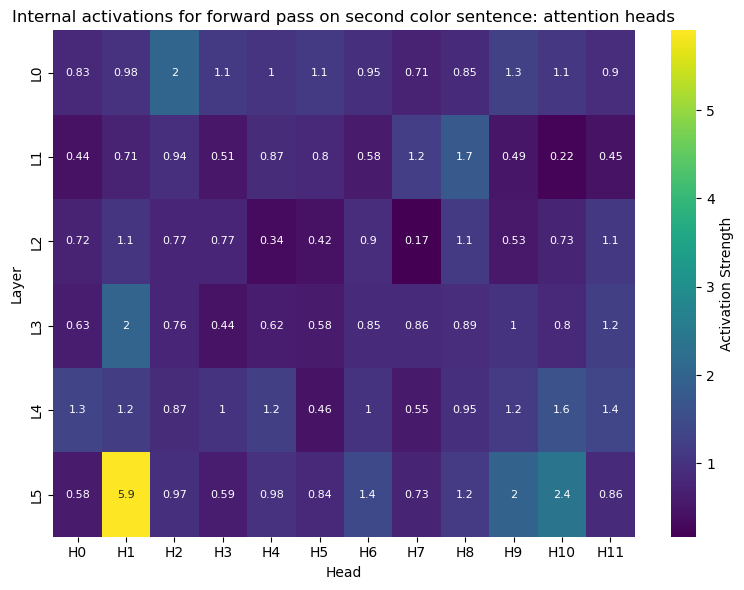

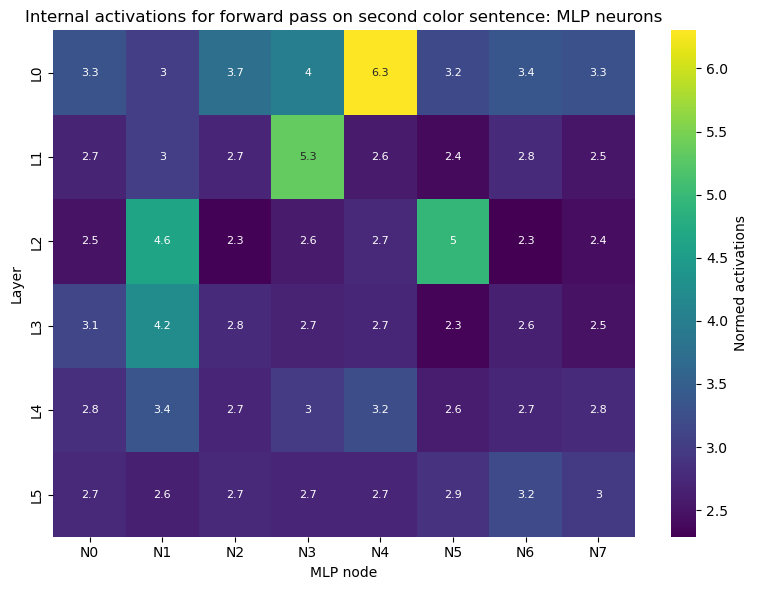

torch.Size([6, 1, 12, 11, 32])
torch.Size([6, 8, 1, 11, 192])


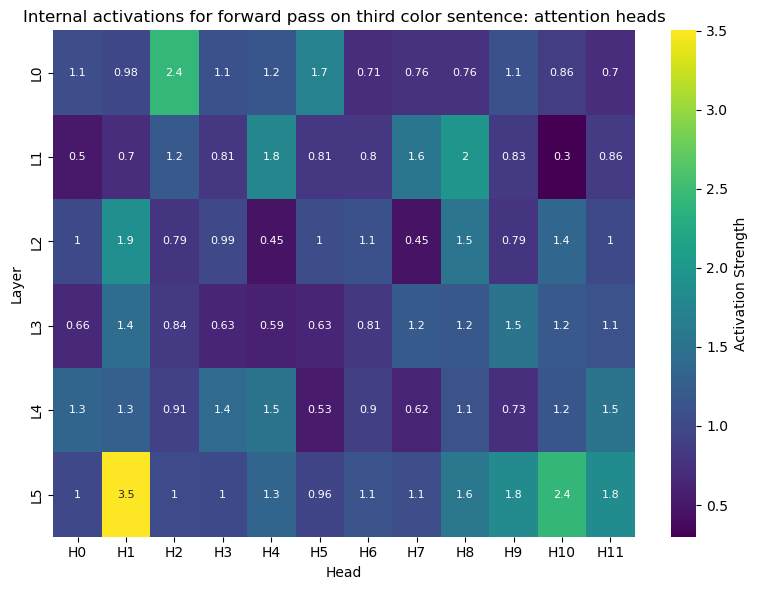

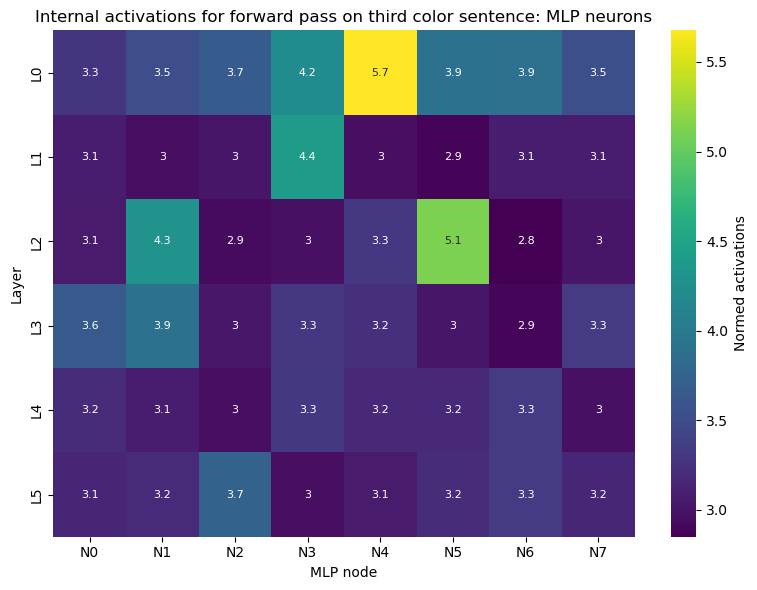

torch.Size([6, 1, 12, 8, 32])
torch.Size([6, 8, 1, 8, 192])


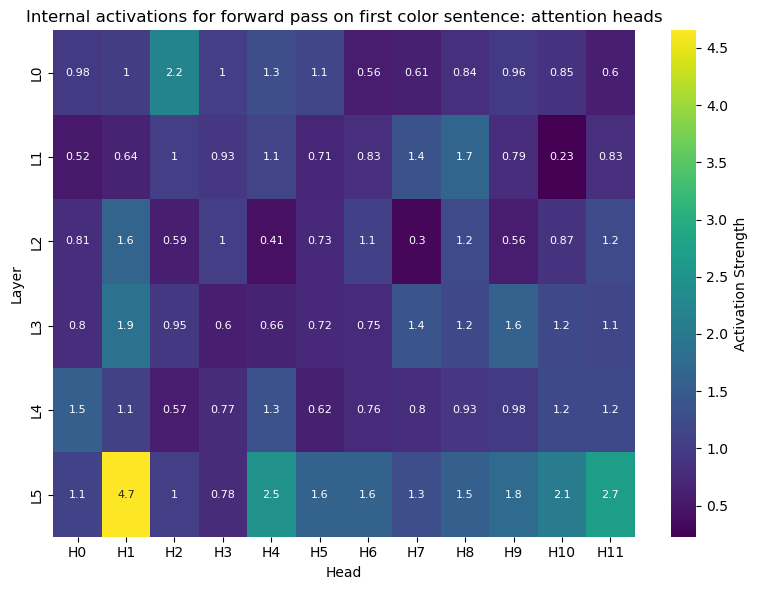

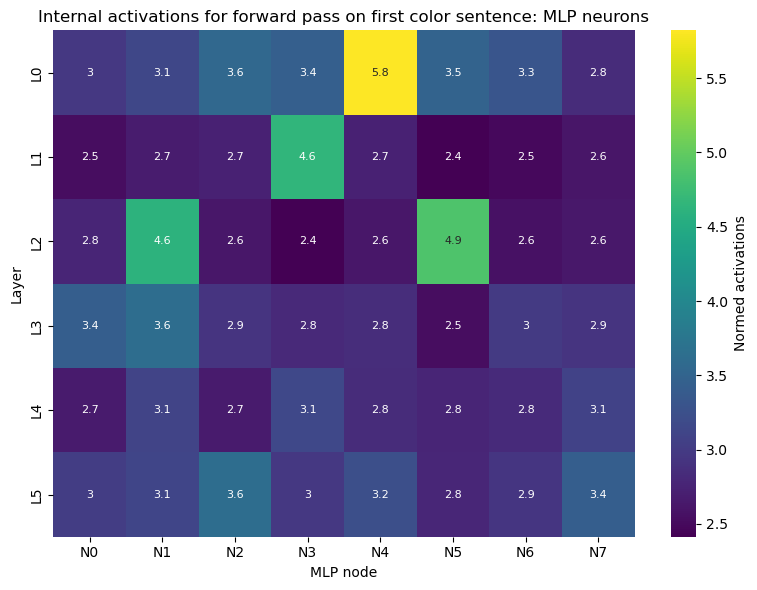

({(0,
   'attn'): tensor([[[[ 6.9256e-02,  8.7994e-03, -1.0735e-02,  ..., -1.7173e-01,
              1.3200e-01, -6.5843e-01],
            [ 1.4454e-01, -3.2674e-02, -5.5945e-02,  ..., -1.0865e-01,
              1.7651e-01, -7.5006e-01],
            [ 1.5917e-01, -1.5855e-01, -9.2503e-02,  ..., -1.0850e-01,
              4.5318e-02, -5.6499e-01],
            ...,
            [ 9.9205e-02, -1.4270e-01, -4.8470e-02,  ..., -1.1114e-01,
              2.0959e-01, -6.4763e-01],
            [ 2.7594e-01,  2.8037e-02, -1.5933e-02,  ...,  3.2376e-02,
              3.0582e-01, -7.7595e-01],
            [ 3.8371e-02, -5.4172e-03, -4.9713e-02,  ..., -1.5022e-01,
              1.6721e-01, -7.1158e-01]],
  
           [[ 1.0463e-02, -7.8597e-02, -2.7608e-02,  ...,  5.5181e-01,
              3.1068e-02,  1.4623e-01],
            [ 8.8073e-02,  5.2443e-02, -4.0759e-03,  ...,  2.5805e-01,
             -9.4782e-02,  1.2431e-01],
            [ 2.8786e-01,  8.4519e-02, -7.5810e-02,  ...,  9.0526e-02,
    

In [ ]:
'''
reference_question = physics_questions[0]
prompt = physics_answers[0]
corr_prompt = wrong_physics_answers["0.0"]

receiver_node = {(3,"MLP"): list(range(192*4,192*5))}

reference_question = "What is the force that pulls objects to the ground?"
prompt = "The force is gravity"
corr_prompt = "The force is air resistance"

reference_question = "What color is the house?"
prompt = "It appears to be blue"
corr_prompt = "It appears to be large"

reference_question = physics_questions[0]
prompt = physics_answers[0]
corr_prompt = wrong_physics_answers["3.0"]

embed_prompt = embed(model,tokenizer(prompt, padding = True, truncation=True, return_tensors='pt'))
embed_corr_prompt = embed(model,tokenizer(corr_prompt, padding = True, truncation=True, return_tensors='pt'))
embed_question_prompt = embed(model,tokenizer(reference_question, padding = True, truncation=True, return_tensors='pt'))

print(embed_prompt.shape)
print("Question and clean prompt: ",1 - F.cosine_similarity(embed_prompt[0],embed_question_prompt[0],dim=0))
print("Question and corrupt prompt: ",1 - F.cosine_similarity(embed_corr_prompt[0],embed_question_prompt[0],dim=0))

visualize_activations(text = prompt,tokens = slice(None),attn_head_act = None,MLP_act = None,num_MLP_neurons = 8)
intervene_on_many_nodes(reference_question, prompt,intervention_type = "ablation", title="Change in cosine distance between question and answer embedding due to answer ablation ", label="Distance change", num_MLP_neurons = 8,alpha=-10)
intervene_on_many_nodes(prompt, corr_prompt,intervention_type = "activation patching", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8)
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, corr_prompt = corr_prompt,intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8)
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8,alpha = -2.0)
'''

color_sentence_1 = "The skies here are so blue"
color_sentence_2 = "Is is clearly red"
color_sentence_3 = "I am looking at the yellow flowers over there"

test_attn_act, test_MLP_act = visualize_activations(text = color_sentence_1,title = "Internal activations for forward pass on first color sentence:", num_MLP_neurons = 8)
visualize_activations(text = color_sentence_2,title = "Internal activations for forward pass on second color sentence:", num_MLP_neurons = 8)
visualize_activations(text = color_sentence_3,title = "Internal activations for forward pass on third color sentence:", num_MLP_neurons = 8)
visualize_activations(title = "Internal activations for forward pass on first color sentence:", attn_head_act = test_attn_act, MLP_act = test_MLP_act, num_MLP_neurons = 8)

To demonstrate the power of activation patching, we will create corrupted prompts replacing the color word with a different one. It is found that patching the activations of the head H1 at the last layer causes the distance between the clean and corrupt prompt to shrink appreciably. In fact, the distance shrinks by approximately 50 % (48 and 53 % in the two cases shown), which is the majority of the original distance between the embedding vectors of the clean and corrupt color sentences - a clear sign that this attention head provides the majority of the representation of the color word!  

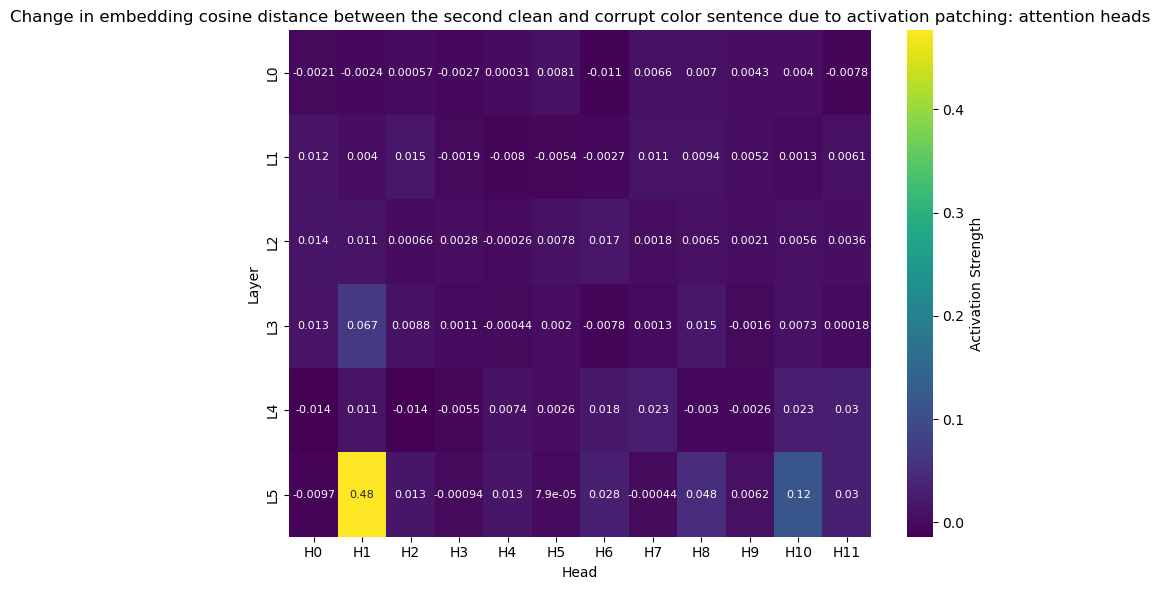

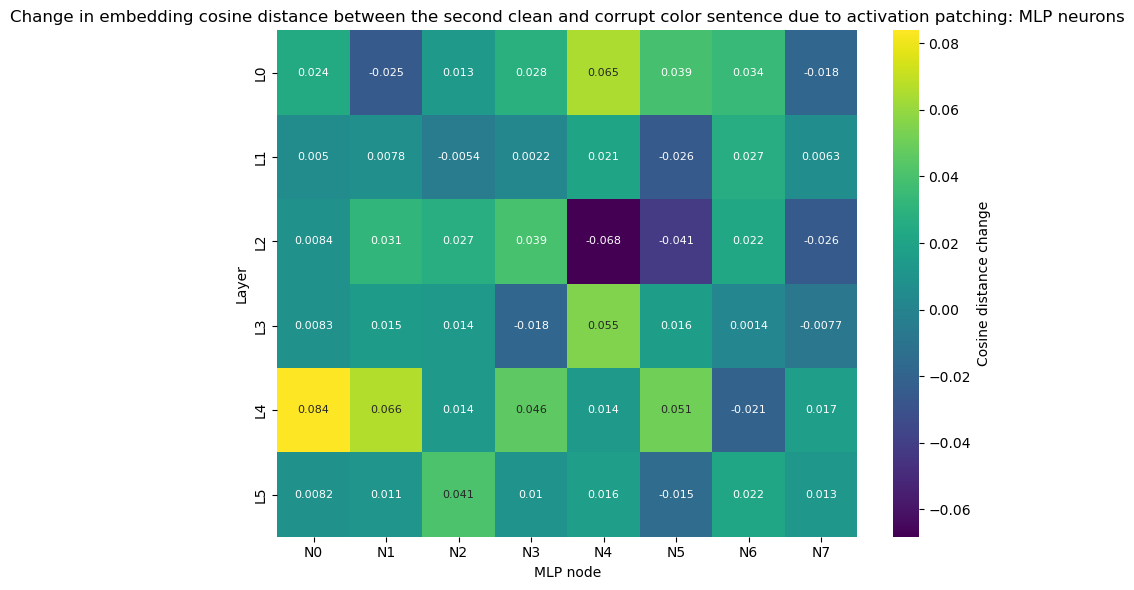

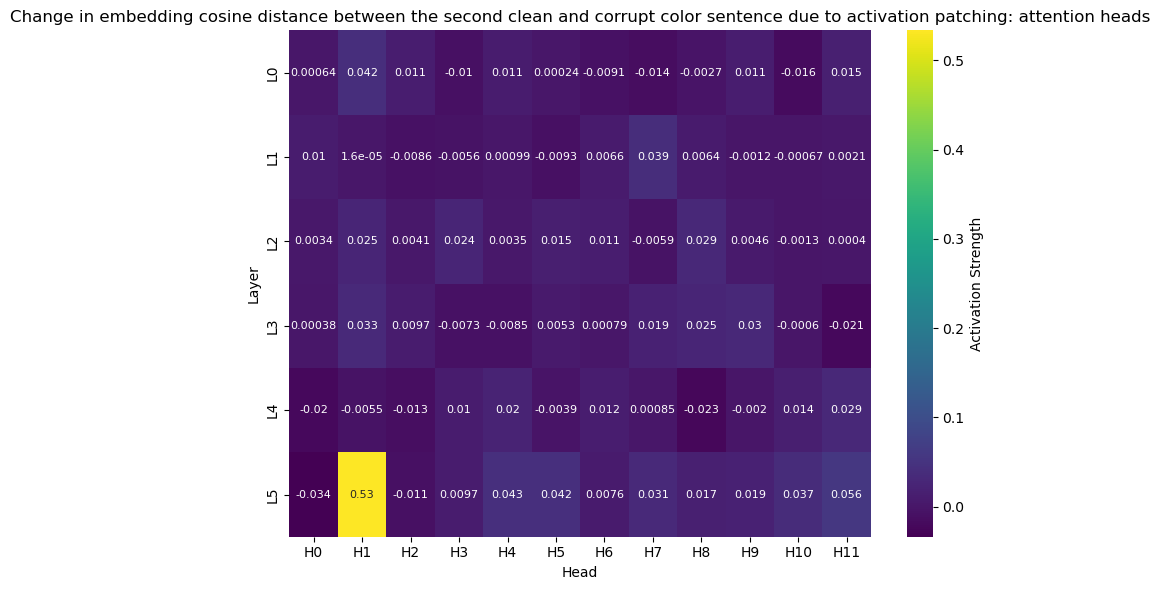

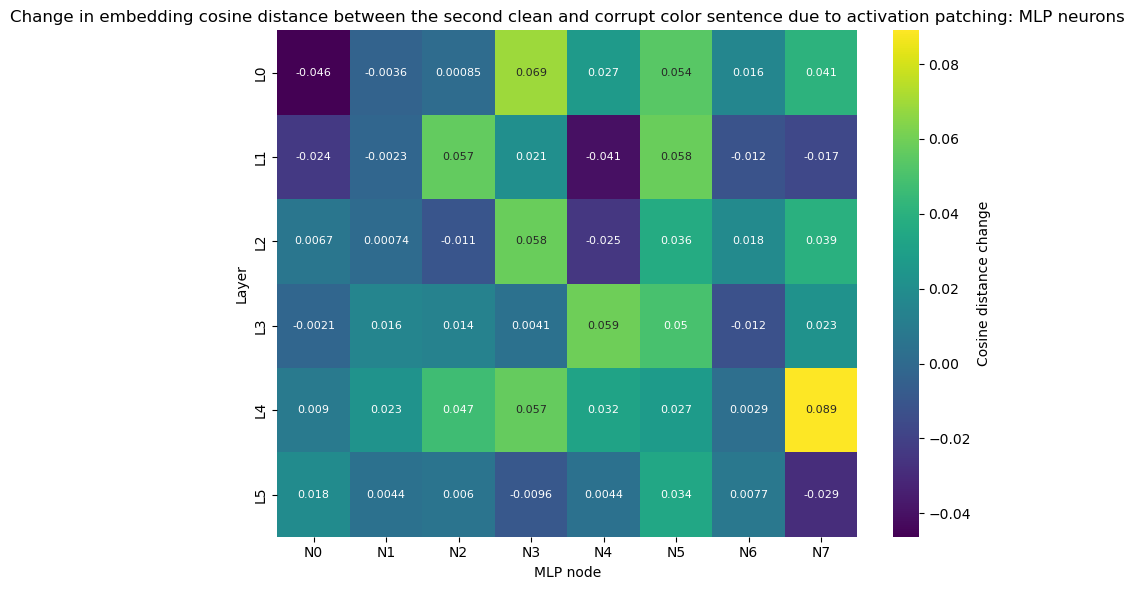

In [57]:
corrupt_color_sentence_2 = "It is clearly mine"
corrupt_color_sentence_3 = "I am looking at the majestic flowers over there"

intervene_on_many_nodes(color_sentence_2, corrupt_color_sentence_2,intervention_type = "activation patching", title="Change in embedding cosine distance between the second clean and corrupt color sentence due to activation patching:", label="Cosine distance change", num_MLP_neurons = 8)

intervene_on_many_nodes(color_sentence_3, corrupt_color_sentence_3,intervention_type = "activation patching", title="Change in embedding cosine distance between the second clean and corrupt color sentence due to activation patching:", label="Cosine distance change", num_MLP_neurons = 8)

I wish to show something else that is interesting. One intuitive thought would be to visualize the activations on only the color token. After all, my visualize_activations function allows you to select the desired tokens to visualize the activations! For instance, in the third color sentence, the color word "red" is the sixth token. By passing tokens = [5] into the visualize_activations function (note that the index starts at 0, so the sixth token has index 5), we actually find that attention head H1 is not the most activate attention head (rather, it is attention head H1 at layer L2). You can see that below. 

torch.Size([6, 1, 12, 1, 32])
torch.Size([6, 8, 1, 1, 192])


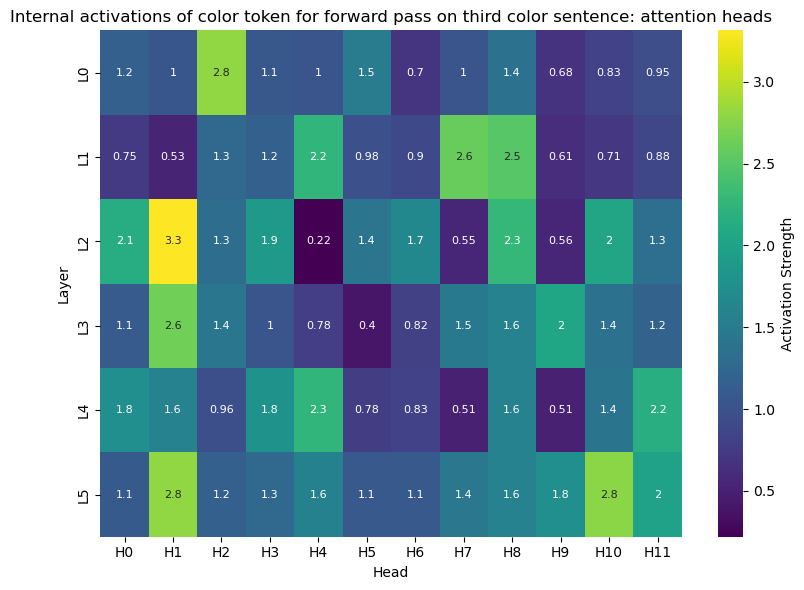

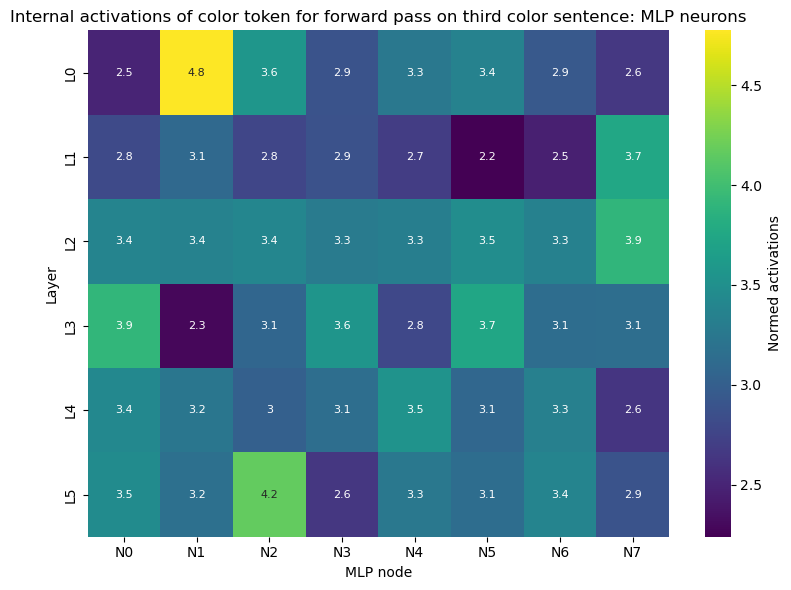

In [58]:
visualize_activations(text = color_sentence_3,title = "Internal activations of color token for forward pass on third color sentence:", tokens = [5], num_MLP_neurons = 8)

One might think that this contradicts my statement that colors are represented by attention head H1 at the last attention layer. However, I think there is another explanation - the point is that the activations of different tokens are mixed in attention layers (due to the attention mechanism). Layer L5 is at the last layer, and so the activations at head H1 in the last layer have soaked up information from other tokens in many previous layers. Color sentence 3 is a rather long sentence, so there is much information to soak up from other tokens. 

The implementation of activation patching above shows that it is still attention head H1 at layer L5 that provides the biggest decrease in distance between the clean and corrupt version of the third color sentence. Again, note the power of activation patching for unentangling exactly which parts of the input text prompt that causes the activations at the various nodes in the network! 

Next, I will provide some examples of the typical behavior of ablation that I found when I tried it on different questions and answer combinations. 

I write a question for color sentence 2 and ablate each attention head and MLP node. We visualize the resulting decrease (for positive values) or increase (for negative values) in the embedding distance between the question and answer. 

In the first case below, we implement ordinary zero ablation - namely, we use $\alpha = 0$. 

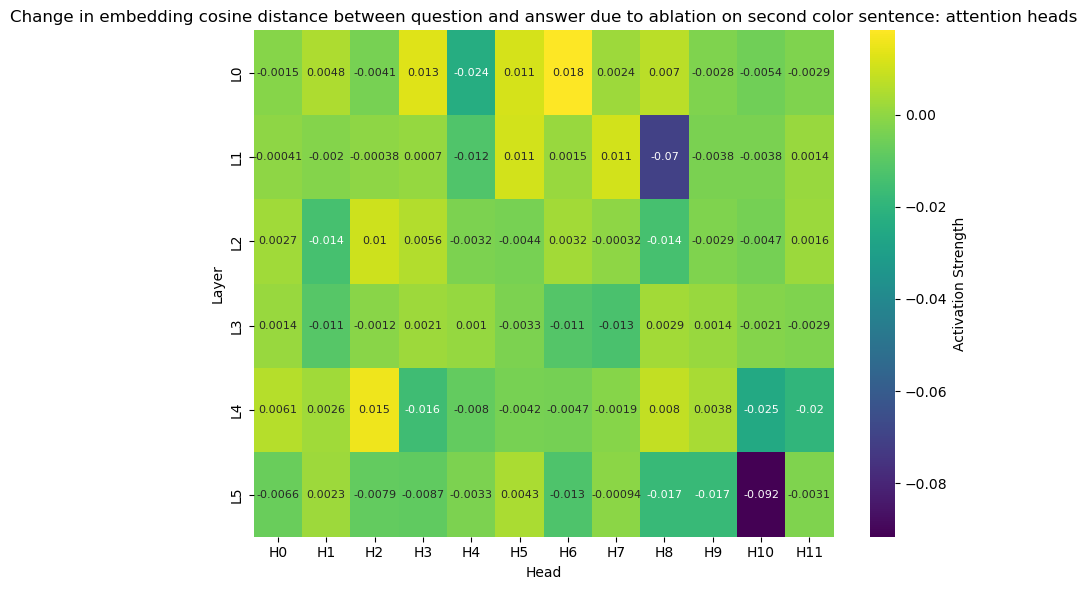

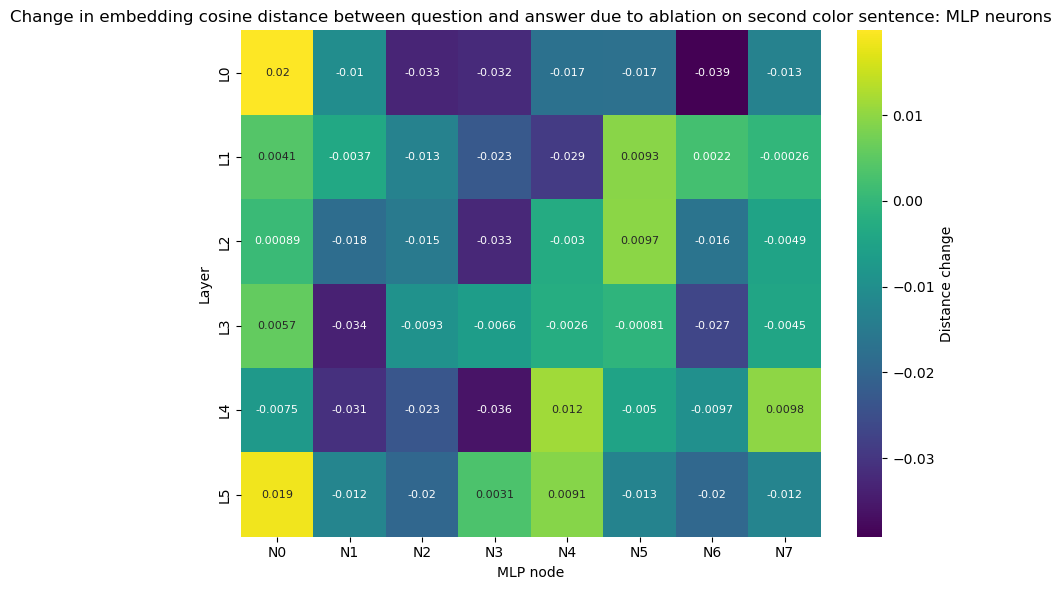

In [62]:
reference_question_color_sentence_2 = "What is the color of this house?"

intervene_on_many_nodes(reference_question_color_sentence_2, color_sentence_2,intervention_type = "ablation", title="Change in embedding cosine distance between question and answer due to ablation on second color sentence:", label="Distance change", num_MLP_neurons = 8,alpha = 0.0)

Notice that ablating the activations at attention head H1 in layer L5 has nearly no effect. Strangely, it appears that ablating activations on attention head H10 and layer L5 causes a much bigger increase in distance between the question and answer. Next, we will show the result with a negative $\alpha$ value with large absolute value. We will motivate this choice below. 

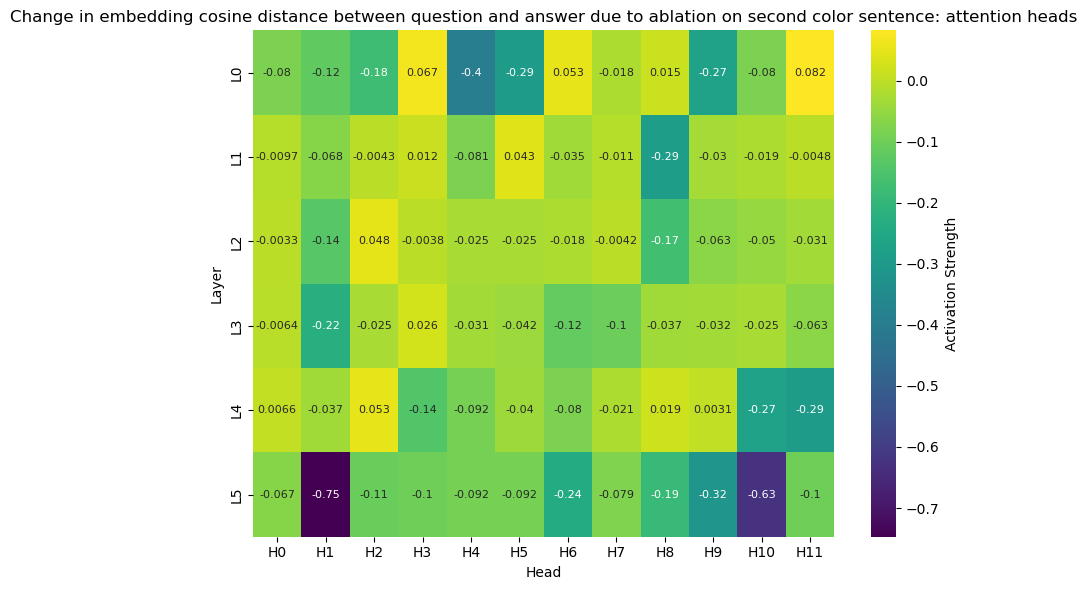

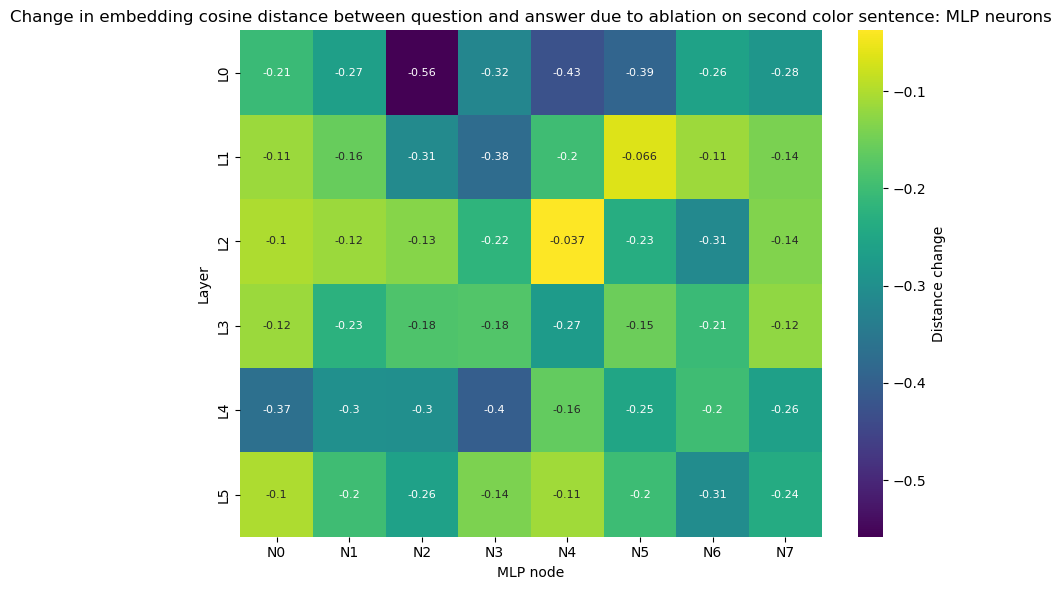

In [81]:
intervene_on_many_nodes(reference_question_color_sentence_2, color_sentence_2,intervention_type = "ablation", title="Change in embedding cosine distance between question and answer due to ablation on second color sentence:", label="Distance change", num_MLP_neurons = 8,alpha = -5.0)

Now we suddenly see that ablating attention head H1 causes the biggest increase in distance between the question and answer! I found a similar pattern for other questions and answer combinations where a single word (such as a color) provided the answer to the question. Generically, it appears that many extra attention heads (compared to the ones that showed up with activation patching or from visualizing activations) have a significant effect when performing zero ablation, but that the attention heads you expect start to appear when you set $\alpha$ equal to some negative number with large absolute value. 

This might be somewhat expected. Simply setting the activations equal to zero could have unintended consequences. In Neel Nanda's glossary ([source](https://www.neelnanda.io/mechanistic-interpretability/glossary)) and the Interpretability in the Wild paper ([Wang et al., 2022](https://arxiv.org/pdf/2211.00593#page=14&zoom=100,110,108)), it is pointed out that there might be a bias term in the activations, and setting these activations equal to zero might simply remove this bias. The idea I had was to multiply by a negative number with large absolute value, as that *reverses* the effect of the node and amplifies the reversed activations. The idea was that this would enhance the contrast between the effects of different nodes, and cause the most important nodes to stand out. The results mentioned before give some weak evidence for this. 

However, this still does not explain why other, previously unknown attention heads have a large effect when performing ablation. This could be a good sign - perhaps ablation is, after all, a useful tool for enhancing important nodes that are missed by other analysis tools? The attention head H10 at layer L5 does not seem entirely arbitrary, as it had the second highest activation (of 0.12) in the second color sentence. However, we should not overinterpret our results. Below, I show an example of what happens if we use a physics-question pair from FCI, and the ablation results there appear to be more difficult to interpret. In general, it is often the case that many more attention heads cause a significant difference in distance between the question and answer compared to what one might expect from activation patching. 

We will now show an example of path patching. 

In [ ]:
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, corr_prompt = corr_prompt,intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8)
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8,alpha = -2.0)

### Activation patching



torch.Size([6, 1, 12, 1, 32])
torch.Size([6, 8, 1, 1, 192])


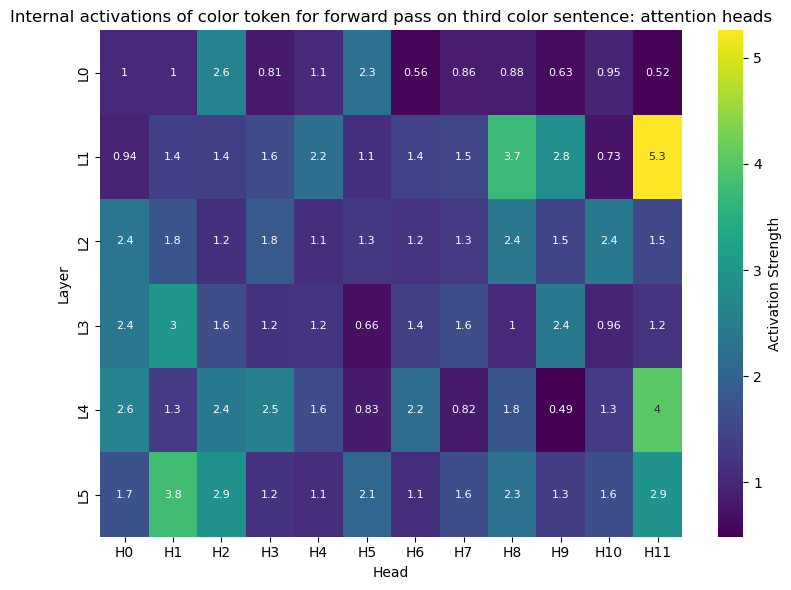

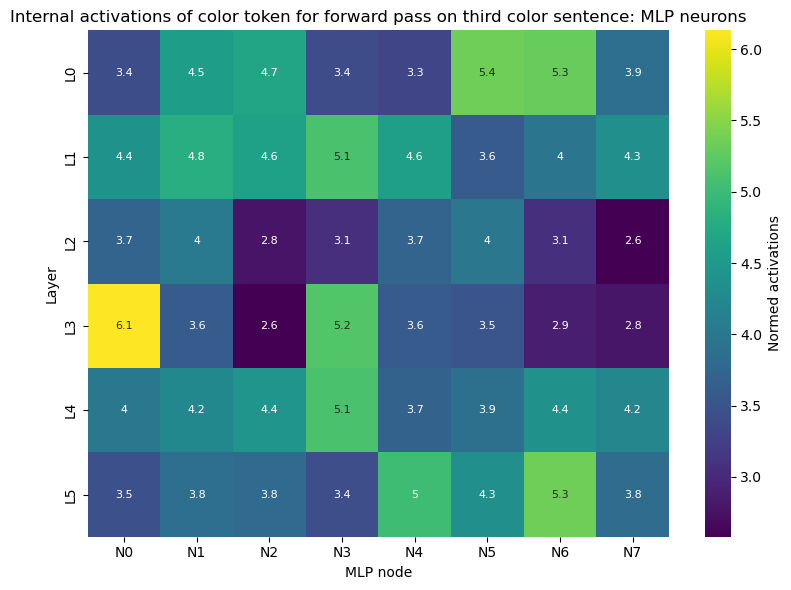

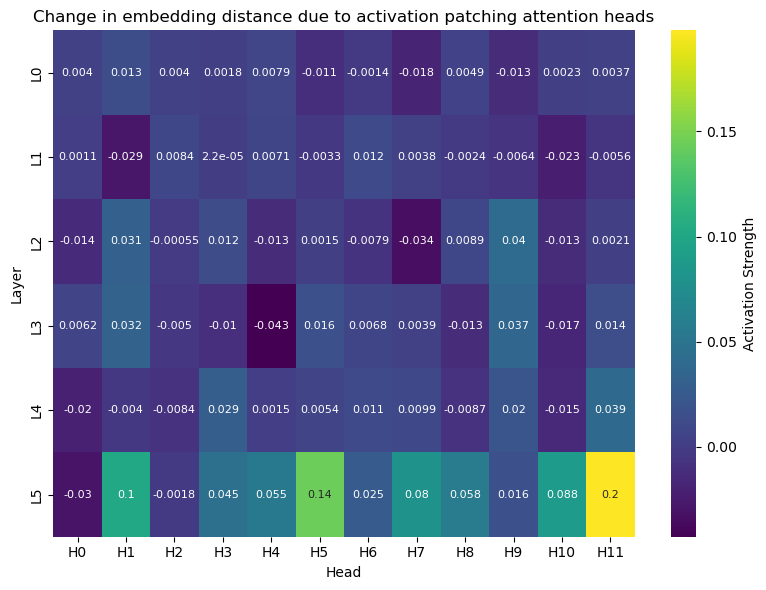

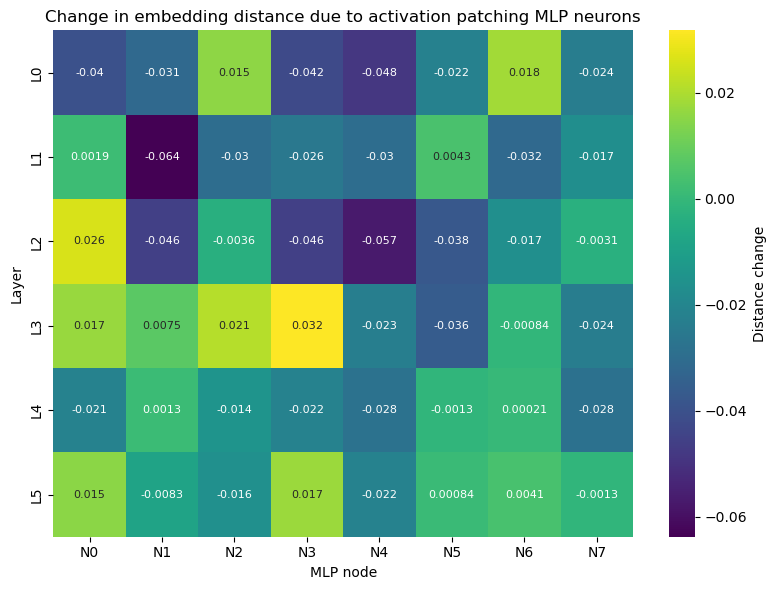

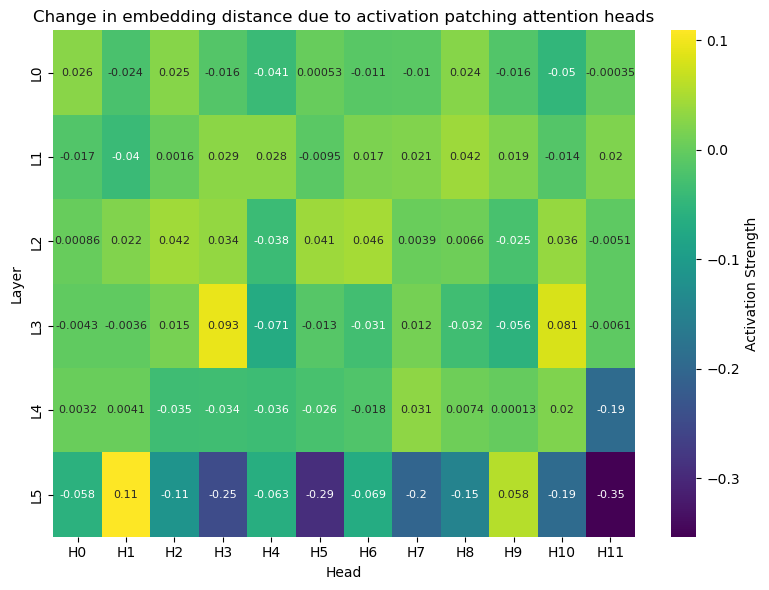

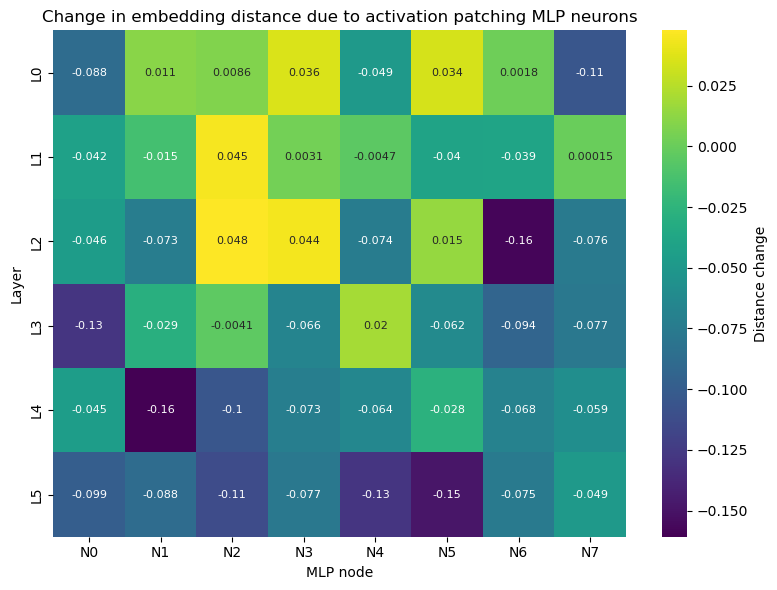

In [80]:
reference_question = "Why does a ball slow down when it rolls on a table?"
clean_prompt = "It happens because of friction"
corr_prompt = "It happens because of gravity"

reference_question = questions[2]
clean_prompt = answers[2]
corr_prompt = answers[3]

clean_prompt2 = "Albert Einstein revolutionized our understanding of blue"
corr_prompt2 = "Albert Einstein revolutionized our understanding of friction"

clean_prompt3 = "We must understand the house of the blue"
corr_prompt3 = "We must understand the yellow of the friction"

clean_prompt4 = "This house is blue"
corr_prompt4 = "This yellow is friction"

clean_prompt5 = "Hello, house! How is it blue"
corr_prompt5 = "Hello, yellow! How is it friction"

visualize_activations(text = clean_prompt,title = "Internal activations of color token for forward pass on third color sentence:", tokens = [5], num_MLP_neurons = 8)
intervene_on_many_nodes(clean_prompt, corr_prompt,intervention_type = "activation patching", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8)

#intervene_on_many_nodes(clean_prompt2, corr_prompt2,intervention_type = "activation patching", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8)

#intervene_on_many_nodes(clean_prompt5, corr_prompt5,intervention_type = "activation patching", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8)

intervene_on_many_nodes(reference_question, clean_prompt,intervention_type = "ablation", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8,alpha = 0.0)

### Ablation 

torch.Size([1, 384])
Question and clean prompt:  tensor(0.2152)
Question and corrupt prompt:  tensor(0.3334)
torch.Size([6, 1, 12, 22, 32])
torch.Size([6, 8, 1, 22, 192])


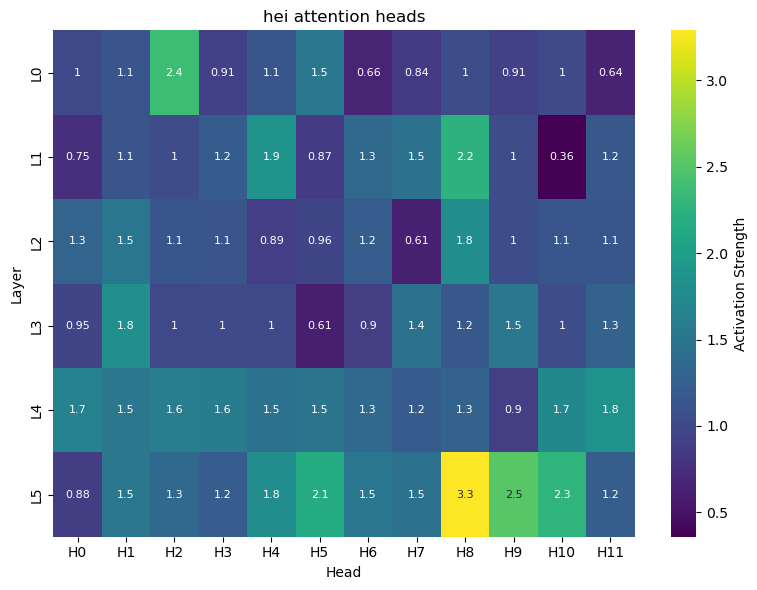

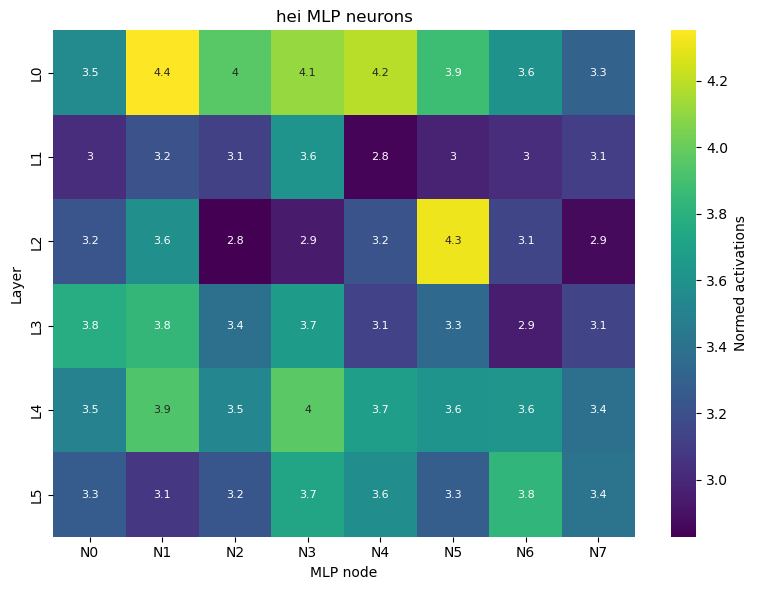

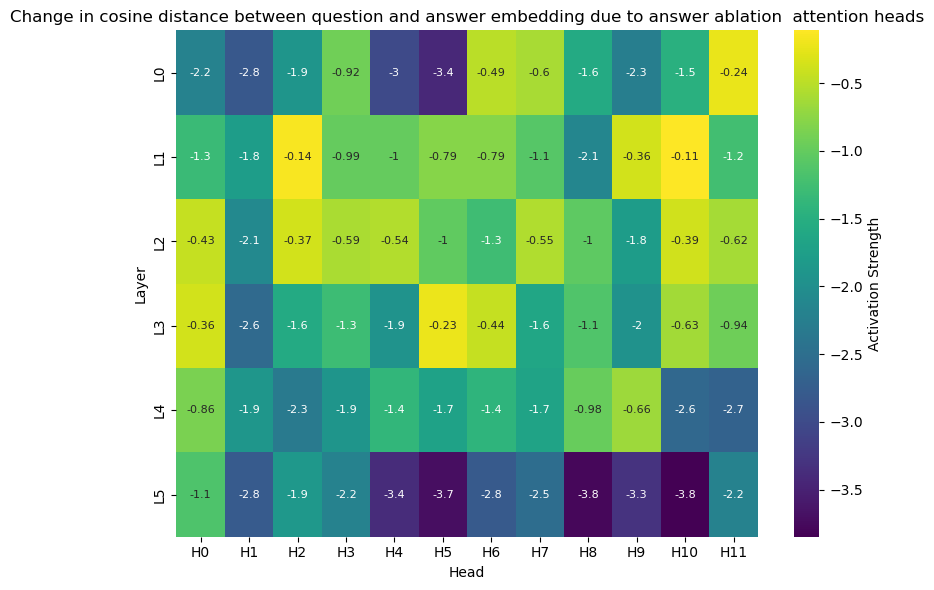

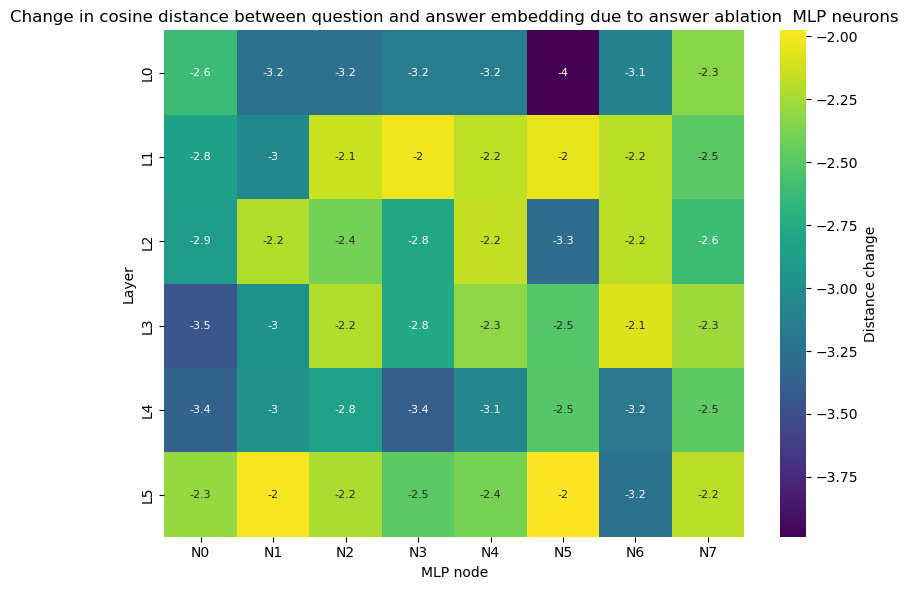

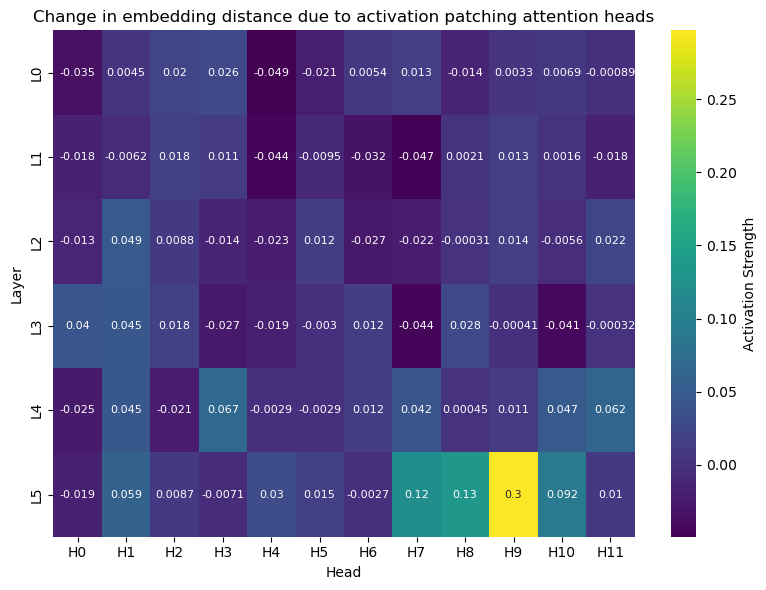

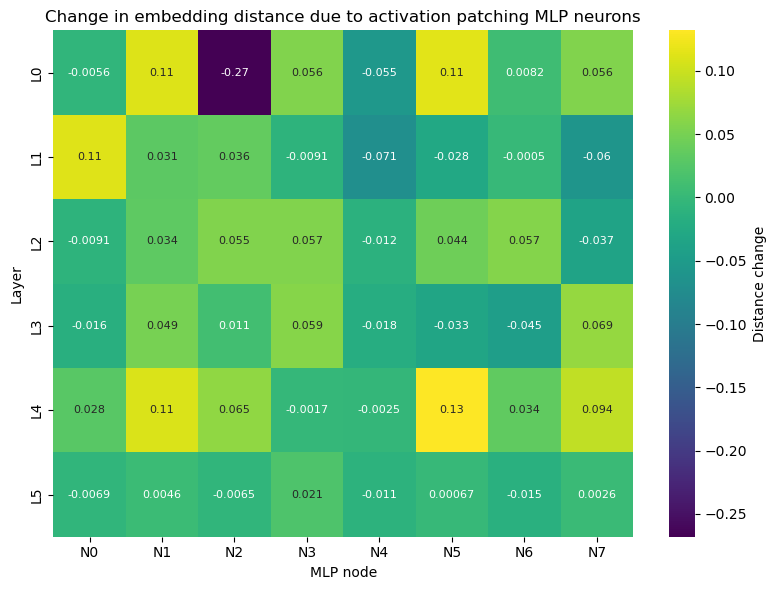

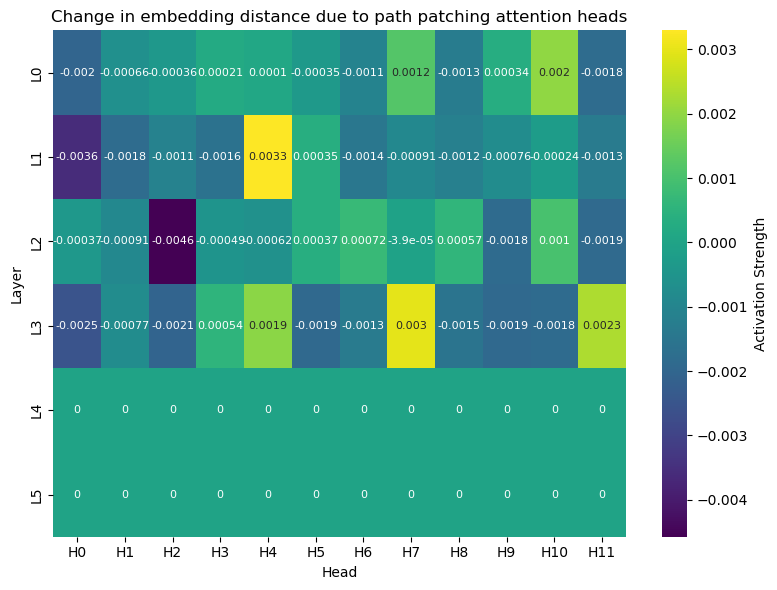

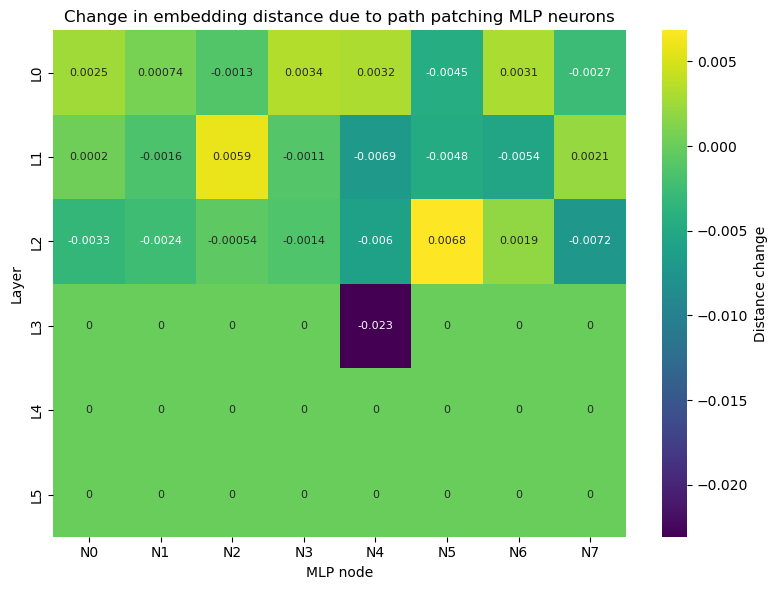

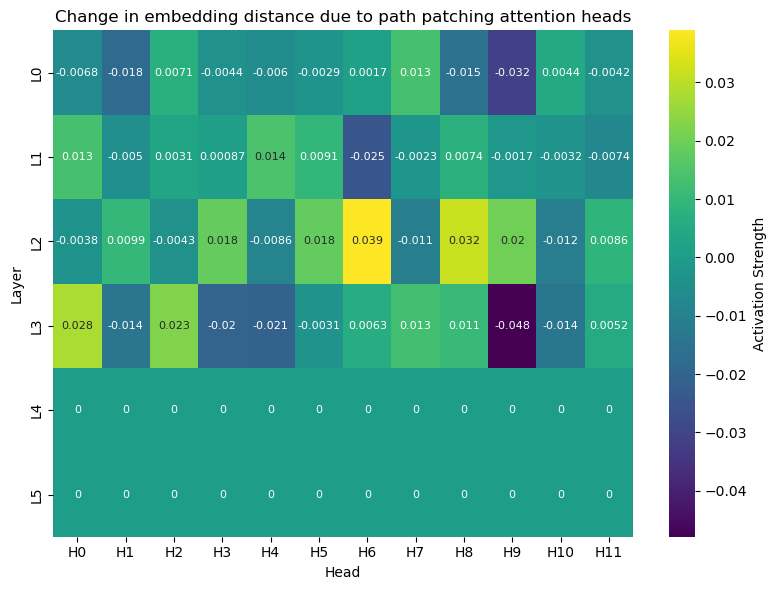

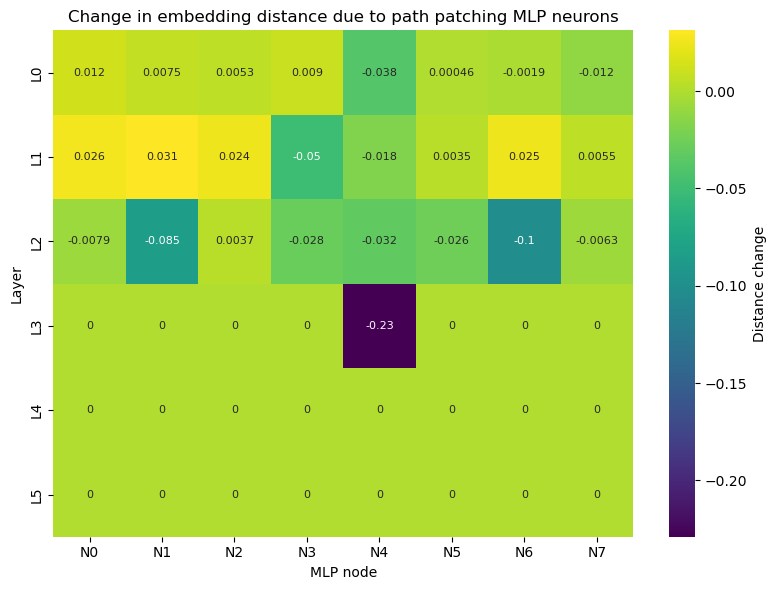

In [82]:
reference_question = physics_questions[0]
prompt = physics_answers[0]
corr_prompt = wrong_physics_answers["0.0"]

receiver_node = {(3,"MLP"): list(range(192*4,192*5))}

reference_question = "What is the force that pulls objects to the ground?"
prompt = "The force is gravity"
corr_prompt = "The force is air resistance"

reference_question = "What color is the house?"
prompt = "It appears to be blue"
corr_prompt = "It appears to be large"

reference_question = physics_questions[0]
prompt = physics_answers[0]
corr_prompt = wrong_physics_answers["3.0"]

embed_prompt = embed(model,tokenizer(prompt, padding = True, truncation=True, return_tensors='pt'))
embed_corr_prompt = embed(model,tokenizer(corr_prompt, padding = True, truncation=True, return_tensors='pt'))
embed_question_prompt = embed(model,tokenizer(reference_question, padding = True, truncation=True, return_tensors='pt'))

print(embed_prompt.shape)
print("Question and clean prompt: ",1 - F.cosine_similarity(embed_prompt[0],embed_question_prompt[0],dim=0))
print("Question and corrupt prompt: ",1 - F.cosine_similarity(embed_corr_prompt[0],embed_question_prompt[0],dim=0))

visualize_activations(text = prompt,title="hei", tokens = slice(None),attn_head_act = None,MLP_act = None,num_MLP_neurons = 8)
intervene_on_many_nodes(reference_question, prompt,intervention_type = "ablation", title="Change in cosine distance between question and answer embedding due to answer ablation ", label="Distance change", num_MLP_neurons = 8,alpha=-10)
intervene_on_many_nodes(prompt, corr_prompt,intervention_type = "activation patching", title="Change in embedding distance due to activation patching", label="Distance change", num_MLP_neurons = 8)
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, corr_prompt = corr_prompt,intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8)
intervene_on_many_nodes(reference_prompt = reference_question, receiver_node = receiver_node, prompt = prompt, intervention_type = "path patching", title="Change in embedding distance due to path patching", label="Distance change", num_MLP_neurons = 8,alpha = -2.0)

In [ ]:
node = {(5,"attn"): 8}

_,new_embedding = path_patching(sender_node = node,clean_prompt = prompt, corr_prompt = corr_prompt, receiver_node = None)

test_distance1 = 1 - F.cosine_similarity(new_embedding[0],embed_question_prompt[0],dim=0)
test_distance2 = 1 - F.cosine_similarity(embed_prompt[0],embed_question_prompt[0],dim=0)

print("Question and new embedding: ",test_distance1)
print("Question and new embedding: ",test_distance2)

print((test_distance2 - test_distance1)/test_distance1)

Question and new embedding:  tensor(0.2258)
Question and new embedding:  tensor(0.2152)
tensor(-0.0472)


### Visualizing attention head and MLP activations

torch.Size([6, 8])


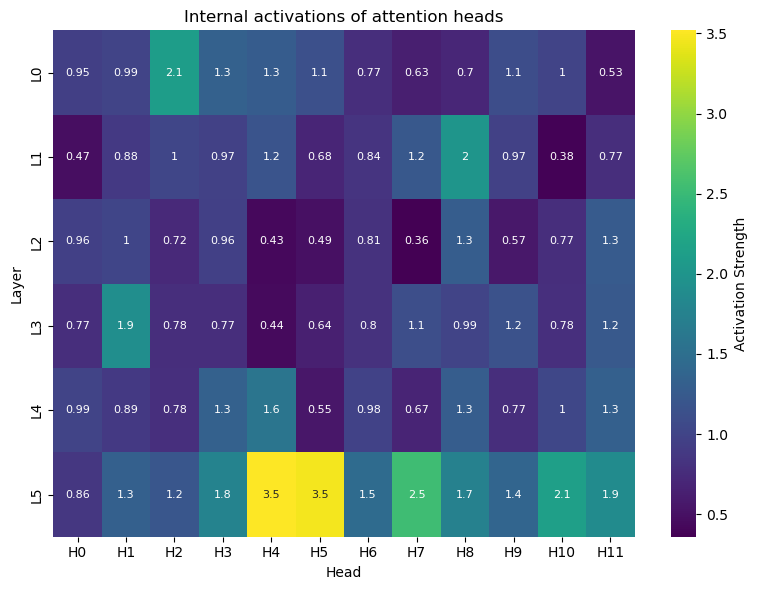

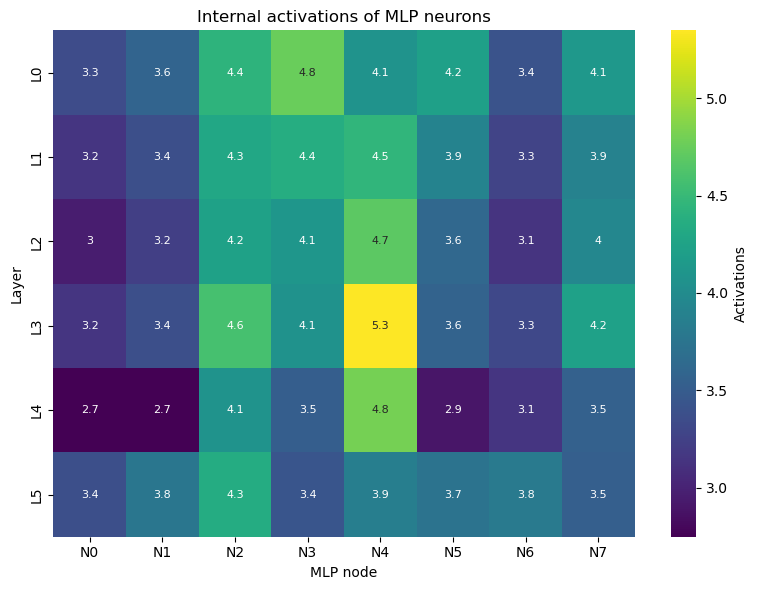

In [ ]:
def visualize_activations(text = None,tokens = slice(None),attn_head_act = None,MLP_act = None,num_MLP_neurons = 1): 

    if attn_head_act == None:
        attn_head_act = {}
        [cache_and_patch_attn_head_activations(i,attn_head_output = attn_head_act,tokens = tokens) for i in range(num_layers)]

    if MLP_act == None:
        MLP_act = {}
        [cache_and_patch_MLP_activations(i, MLP_output = MLP_act, tokens=tokens,final_output = True) for i in range(num_layers)]
    
    if text is not None: 
        embed(model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))

    attn_head_act = torch.stack(list(attn_head_act.values()))
    MLP_act = torch.stack([torch.stack(torch.chunk(el,num_MLP_neurons,dim=-1)) for el in MLP_act.values()])
    #MLP_act = torch.stack(list(MLP_act.values()))

    avg_attn_head_act = torch.norm(attn_head_act, p = 2,dim=-1).mean(dim=[1,3])
    avg_mlp_act = torch.norm(MLP_act, p = 2,dim=-1).mean(dim=[2,3])
    print(avg_mlp_act.shape)

    visualize_attn_head_and_MLP_strengths(avg_attn_head_act, avg_mlp_act,"Internal activations",label="Activations")

visualize_activations(text = "Albert Einstein revolutionized our understanding of gravity",num_MLP_neurons = 8)

### Visualizing path patching

In [ ]:
for title in tab_titles:
    fig = create_plot(title)
    output = widgets.Output()
    with output:
        display(fig)
    tab_contents.append(output)

tabs = widgets.Tab()
tabs.children = tab_contents

for i in range(len(tab_titles)):
    tabs.set_title(i, tab_titles[i])

display(tabs)

NameError: name 'tab_titles' is not defined

In [ ]:
#Function for doing an ablation. 

#zero ablation: set activation to zero
#random ablation: set to random value (eg. Gauss with mean 0 and std 1)
#mean ablation: mean value of all activations in a given layer

'''

def ablation(layer, neuron_idx, data, type = "zero"):
    original_forward = model.encoder.layer[layer].output.forward     #mlp.wo.forward    #mlp.layernorm

    if type == "zero": 
        new_activation = 0.0
    if type == "mean": 
        new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    if type == "random": 
        new_activation = np.random.normal(0.0,1.0)
    if type != "zero" and type != "mean" and type != "random": 
        raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    def change_forward(self,*args,**kwargs):      #self, x
        our = original_forward(*args,**kwargs).clone()        #original_forward(x)
        our[:,:,neuron_idx] = new_activation     #[batch_size (number of prompts), seq_len (number of tokens), hidden_dim)
        return our     #torch.zeros_like(original_wo(*args, **kwargs)
    
    #model.encoder.layer[layer].mlp.forward = change_forward      #mlp.wo.forward
    model.encoder.layer[layer].output.forward = MethodType(change_forward, model.encoder.layer[layer].output)       #mlp.layernorm
    new_embeddings = embed(data,model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))                           #embed(text for text in data)
    model.encoder.layer[layer].output.forward = original_forward     #mlp.wo.forward     #mlp.layernorm

    return new_embeddings

def register_forward_hook(inp_hook,layer_idx,node_type):
    if node_type == "attn": 
        return model.encoder.layer[layer_idx].attention.output.register_forward_hook(inp_hook) 
    if node_type == "MLP": 
        return model.encoder.layer[layer_idx].output.register_forward_hook(inp_hook)
    if node_type != "attn" and type != "MLP": 
        raise ValueError("You must register a hook on either an attention block or a MLP. Thus, type must be either 'MLP' or 'attn'")

        def modified_embeddings(text,layer,neuron_idx,tokens,new_activations,node_type = "MLP",max_tokens = None): 

def modified_embeddings(text,layer,neuron_idx,tokens,new_activations,node_type = "MLP",max_tokens = None): 

    def patching_hook(new_activations): 
        def change_neuron(module, inp, out): 
            orig_output = out.clone()
            orig_output[:,tokens,neuron_idx] = new_activations    # (batch_size, seq_len, hidden_dim)
            return orig_output
        return change_neuron

    patch_handles = list(map(lambda x: register_forward_hook(patching_hook(new_activations(x)),x,node_type),layer))  #handle = model.encoder.layer[layer].output.register_forward_hook(patching_hook)       #mlp.wo.register_forward_hook   #mlp.layernorm

    if max_tokens == None: 
        text_embeddings = embed(model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    else: 
        text_embeddings = embed(model,tokenizer(text, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

    [patch_handle.remove() for patch_handle in patch_handles]

    return text_embeddings

def ablation(layer, neuron_idx, data: list, tokens = None, node_type = "MLP", type = "zero"):

    if tokens == None: 
        tokens = list(range(len(tokenizer(data, add_special_tokens=True)["input_ids"])))

    if type == "zero": 
        def new_activation(x): 
            return 0.0
    
    #if type == "mean": 
        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    #if type == "random": 
        #new_activation = np.random.normal(0.0,1.0)
    #if type != "zero" and type != "mean" and type != "random": 
        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    return modified_embeddings(data,layer,neuron_idx,tokens,new_activation,node_type,max_tokens = None)

def ablation(layer, neuron_idx, data: list, tokens = None, node_type = "MLP", type = "zero"):

    if tokens == None: 
        tokens = list(range(len(tokenizer(data, add_special_tokens=True)["input_ids"])))

    if type == "zero": 
        def new_activation(x): 
            return 0.0
    
    #if type == "mean": 
        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    #if type == "random": 
        #new_activation = np.random.normal(0.0,1.0)
    #if type != "zero" and type != "mean" and type != "random": 
        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    return modified_embeddings(data,layer,neuron_idx,tokens,new_activation,node_type,max_tokens = None)
'''
    
def slice_or_patch(old_tensor, indices, new_values = None):

    for i in range(len(indices)): 
        if isinstance(indices[i], slice):
            indices[i] = torch.arange(old_tensor.shape[i])
        if isinstance(indices[i], list): 
            indices[i] = torch.tensor(indices[i])

    index_grids = torch.meshgrid(*indices, indexing='ij')

    if new_values is None: 
        return old_tensor[index_grids]
    else: 
        old_tensor[index_grids] = new_values
        return old_tensor
    

def cache_and_patch_attn_head_activations(layer_idx,attn_head_output = None,head_idx = slice(None),tokens = slice(None), patch_head_activation = None,alpha = None):

    def forward(self, hidden_states, attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[tuple[tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False) -> tuple[torch.Tensor]:
        
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores/math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = F.softmax(attention_scores,dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        if attn_head_output is not None: 
            attn_head_output[(layer_idx, "attn")] = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)])                                           #context_layer.clone()    # shape: (batch_size, attention_head, seq_len, attn_dim)     attn_head_output[layer_idx] = context_layer.clone().detach()

        '''
        if tokens != slice(None): 
            updated_head_idx, updated_tokens = torch.meshgrid(torch.tensor(head_idx), torch.tensor(tokens), indexing='ij')
        else: 
            updated_head_idx, updated_tokens = head_idx, tokens
        '''

        if alpha is not None: 
            new_activations = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)]) * alpha
            context_layer = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)],new_activations)                                                         #orig_output[:,updated_tokens,updated_neuron_idx] *= alpha 
        else: 
            if patch_head_activation is not None: 
                context_layer = slice_or_patch(context_layer.clone(),[slice(None),head_idx,tokens,slice(None)],patch_head_activation)

        '''
        if alpha is not None: 
            context_layer[:,updated_head_idx,updated_tokens,:] *= alpha
        else: 
            if (patch_head_activation is not None) and (head_idx is not None): 
                context_layer[:,updated_head_idx,updated_tokens,:] = patch_head_activation
        '''
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs)

        return outputs
    model.encoder.layer[layer_idx].attention.self.forward = MethodType(forward, model.encoder.layer[layer_idx].attention.self)

def cache_and_patch_MLP_activations(layer_idx, MLP_output = None, neuron_idx = slice(None), tokens=slice(None), patch_neuron_activation = None,alpha = None):

    global handles 

    def hook_neuron(module, inp, out): 
        orig_output = out.clone()

        if MLP_output is not None: 
            MLP_output[(layer_idx, "MLP")] = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx])                                           #orig_output      # MLP_output[layer_idx] = orig_output[:,:,:].detach()

        '''
        if tokens != slice(None): 
            updated_tokens, updated_neuron_idx = torch.meshgrid(torch.tensor(tokens), torch.tensor(neuron_idx), indexing='ij')
        else: 
            updated_tokens, updated_neuron_idx = tokens, neuron_idx
        '''

        if alpha is not None: 
            new_activations = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx]) * alpha
            orig_output = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx],new_activations)                                                         #orig_output[:,updated_tokens,updated_neuron_idx] *= alpha 
        else: 
            if patch_neuron_activation is not None: 
                orig_output = slice_or_patch(orig_output,[slice(None),tokens,neuron_idx],patch_neuron_activation)
                                                                                   #orig_output[:,updated_tokens,updated_neuron_idx] = patch_neuron_activation

        return orig_output
    
    handles.append(model.encoder.layer[layer_idx].output.register_forward_hook(hook_neuron))

def cache_and_patch_activations(node_type, layer_idx, output = None, node_idx = slice(None), tokens = slice(None), patch_activation = None,alpha = None): 

    if not isinstance(node_idx,(list,slice)):
        node_idx = [node_idx]

    if not isinstance(tokens,(list,slice)):
        tokens = [tokens]

    if node_type == "MLP": 
        cache_and_patch_MLP_activations(layer_idx = layer_idx,MLP_output = output, neuron_idx = node_idx, tokens = tokens, patch_neuron_activation = patch_activation,alpha = alpha)
    if node_type == "attn": 
        cache_and_patch_attn_head_activations(layer_idx = layer_idx,attn_head_output = output, head_idx = node_idx, tokens = tokens, patch_head_activation = patch_activation,alpha = alpha)


def remove_handles_and_retrieve_original_forward(): 

    global handles

    [handle.remove() for handle in handles]
    #handles = []
    handles.clear()
    for i in range(num_layers): 
        model.encoder.layer[i].attention.self.forward = MethodType(original_forward,model.encoder.layer[i].attention.self)

def cache_and_patch_on_many_nodes(nodes,new_activations = None,tokens = None,old_activations = None,alpha = None):    # nodes: {[layer,"MLP/attn"]: node_indices}

    if tokens is None: 
        tokens = []
    if new_activations is None: 
        new_activations = {}

    layers = []
    node_indices = []
    node_types = []

    for location, node in nodes.items(): 
        layers.append(location[0])
        node_indices.append(node)
        node_types.append(location[1])
        if len(node_types) > len(tokens): 
            tokens.append(slice(None))

        if not((location[0],location[1]) in new_activations): 
            new_activations[(location[0],location[1])] = None
        '''
        else:  
            if location[1] == "MLP": 
                new_activations[(location[0],"MLP")] = new_activations[(location[0],"MLP")][:,tokens[len(layers) - 1],node]   #len(layers) - 1 is the index of the location-node pair in the nodes dict
            if location[1] == "attn": 
                new_activations[(location[0],"attn")] = new_activations[(location[0],"attn")][:,node,tokens[len(layers) - 1],:]
        '''
    for i in range(len(layers)): 
        cache_and_patch_activations(node_type = node_types[i], layer_idx = layers[i], output = old_activations, node_idx = node_indices[i], tokens = tokens[i], patch_activation = new_activations[(layers[i],node_types[i])],alpha = alpha)

def path_patching(orig_prompt,corr_prompt,sender_node,receiver_node):     #sender_node, receiver_node. ([layer,"MLP/attn"]: node_indices)

    if corr_prompt is not None:
        max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))


    '''
    sender_node_type = list(sender_node.values())[0]
    sender_location = [int(el) for el in list(sender_node.keys())[0].split(".")]
 
    receiver_node_type = list(receiver_node.values())[0]
    receiver_location = [int(el) for el in list(receiver_node.keys())[0].split(".")]
    '''

    #  ------ STEP 1 -----

    #Clean

    clean_attn_heads = {}

    attn_head_nodes = {(i,"attn"): list(range(num_heads)) for i in range(num_layers)}

    cache_and_patch_on_many_nodes(attn_head_nodes,old_activations = clean_attn_heads)

    orig_embedding = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    #Corrupted

    corr_sender_node_act = {}

    cache_and_patch_on_many_nodes(sender_node, old_activations = corr_sender_node_act)                                                      #cache_and_patch_activations(node_type = sender_node_type, layer_idx = sender_location[0],output = corr_sender_node_act)

    embed(model, tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()
    
    # ------- STEP 2 ------

    freezed_attn_head_nodes = dict(list(attn_head_nodes.items())[list(sender_node.keys())[0][0] + 1:list(receiver_node.keys())[0][0]])

    cache_and_patch_on_many_nodes(freezed_attn_head_nodes,new_activations = clean_attn_heads)

    cache_and_patch_on_many_nodes(sender_node, new_activations = corr_sender_node_act)

    receiver_node_act = {}

    cache_and_patch_on_many_nodes(receiver_node, old_activations = receiver_node_act)

    embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''

    for i in range(receiver_location[0]): 
        if i > sender_location[0]: 
            cache_and_patch_activations(node_type = "attn", layer_idx = i,node_idx = list(range(num_heads)),patch_activation = clean_attn_heads[i])

    if sender_node_type == "MLP": 
        patch_activation = corr_sender_node_act[0][:,:,sender_location[1]]
    if sender_node_type == "attn": 
        patch_activation = corr_sender_node_act[0][:,sender_location[1],:,:]

    

    cache_and_patch_MLP_activations(node_type = sender_node_type,layer_idx = sender_location[0],node_idx = sender_location[1], patch_activation = patch_activation)

    receiver_node_act = []

    cache_and_patch_activations(node_type = receiver_node_type, layer_idx = receiver_location[0],output = receiver_node_act)

    embed(model,tokenizer(orig_prompt, padding=True, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''

    # -------- STEP 3 ---------

    cache_and_patch_on_many_nodes(receiver_node, new_activations = receiver_node_act)

    new_embedding = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''
    if receiver_node_type == "MLP": 
        patch_activation = receiver_node_act[0][:,:,receiver_location[1]]
    if receiver_node_type == "attn": 
        patch_activation = receiver_node_act[0][:,receiver_location[1],:,:]

    cache_and_patch_activations(node_type = receiver_node_type, layer_idx = receiver_location[0],node_idx = receiver_location[1], patch_activation = patch_activation)

    new_embedding = embed(model,tokenizer(orig_prompt, padding=True, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    '''

    return orig_embedding, new_embedding


def ablate(nodes, data: list, tokens = None, alpha = 0.0):

    cache_and_patch_on_many_nodes(nodes,tokens = tokens, alpha = alpha)

    ablated_embedding = embed(model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))

    remove_handles_and_retrieve_original_forward()
    
    #if type == "mean": 
        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    #if type == "random": 
        #new_activation = np.random.normal(0.0,1.0)
    #if type != "zero" and type != "mean" and type != "random": 
        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    return ablated_embedding


def activation_patch(orig_prompt, corr_prompt,nodes): 

    max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

    orig_activations = {}
    cache_and_patch_on_many_nodes(nodes,old_activations = orig_activations)
    orig_embeddings = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    cache_and_patch_on_many_nodes(nodes,new_activations = orig_activations)
    corr_embeddings = embed(model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    remove_handles_and_retrieve_original_forward()

    return 1 - F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)






'''

def ablation(layer, neuron_idx, data: list, tokens = None, type = "zero"):

    if tokens == None: 
        tokens = list(range(len(tokenizer(data, add_special_tokens=True)["input_ids"])))

    for i in layer: 
        model.encoder.layer[i].output.original_forward = model.encoder.layer[i].output.forward     #mlp.wo.forward    #mlp.layernorm

    if type == "zero": 
        new_activation = 0.0
    

    #if type == "mean": 
        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))
    #if type == "random": 
        #new_activation = np.random.normal(0.0,1.0)
    #if type != "zero" and type != "mean" and type != "random": 
        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")

    

    def change_forward(self,*args,**kwargs):      #self, x
        our = self.original_forward(*args,**kwargs).clone()        #original_forward(x)
        for token in tokens: 
            our[:,token,neuron_idx] = new_activation     #[batch_size (number of prompts), seq_len (number of tokens), hidden_dim)
        return our     #torch.zeros_like(original_wo(*args, **kwargs)

        
    #model.encoder.layer[layer].mlp.forward = change_forward      #mlp.wo.forward
    for i in layer: 
        model.encoder.layer[i].output.forward = MethodType(change_forward, model.encoder.layer[i].output)       #mlp.layernorm
    new_embeddings = embed(data,model,tokenizer(data, padding = True, truncation=True, return_tensors='pt'))   
    for i in layer:                        #embed(text for text in data)
        model.encoder.layer[i].output.forward = model.encoder.layer[i].output.original_forward     #mlp.wo.forward     #mlp.layernorm

    return new_embeddings

    '''


'\n\ndef ablation(layer, neuron_idx, data: list, tokens = None, type = "zero"):\n\n    if tokens == None: \n        tokens = list(range(len(tokenizer(data, add_special_tokens=True)["input_ids"])))\n\n    for i in layer: \n        model.encoder.layer[i].output.original_forward = model.encoder.layer[i].output.forward     #mlp.wo.forward    #mlp.layernorm\n\n    if type == "zero": \n        new_activation = 0.0\n\n\n    #if type == "mean": \n        #new_activation = np.sum(np.array([original_forward[:,:,i]] for i in range(len(emb_dim))))\n    #if type == "random": \n        #new_activation = np.random.normal(0.0,1.0)\n    #if type != "zero" and type != "mean" and type != "random": \n        #raise ValueError("The type you wrote does not exist! Use either zero, mean or random for the ablation type")\n\n\n\n    def change_forward(self,*args,**kwargs):      #self, x\n        our = self.original_forward(*args,**kwargs).clone()        #original_forward(x)\n        for token in tokens: \n     

In [ ]:
'''

from types import MethodType
import torch.nn as nn

# Dummy module with forward
class DummyMLP(nn.Module):
    def forward(self, x):
        return x * 2

# Model setup
model = nn.Module()
model.mlp = DummyMLP()

# Save original forward
original_forward = model.mlp.forward

# Define new forward WITH `self`
def change_forward(self, x):
    out = original_forward(x)
    out[:, 0] = 0  # example change
    return out

# Bind correctly
model.mlp.forward = MethodType(change_forward, model.mlp)

# Test it
x = torch.ones(3, 5)
print(model.mlp(x))  # Should work, no errors

'''

'\n\nfrom types import MethodType\nimport torch.nn as nn\n\n# Dummy module with forward\nclass DummyMLP(nn.Module):\n    def forward(self, x):\n        return x * 2\n\n# Model setup\nmodel = nn.Module()\nmodel.mlp = DummyMLP()\n\n# Save original forward\noriginal_forward = model.mlp.forward\n\n# Define new forward WITH `self`\ndef change_forward(self, x):\n    out = original_forward(x)\n    out[:, 0] = 0  # example change\n    return out\n\n# Bind correctly\nmodel.mlp.forward = MethodType(change_forward, model.mlp)\n\n# Test it\nx = torch.ones(3, 5)\nprint(model.mlp(x))  # Should work, no errors\n\n'

Function for doing an activation patching. Returns cosine similarity and L2 norm difference between the embeddings of the corrupted and clean prompts. 

In [ ]:

def activation_patching(orig_prompt, corr_prompt,layer,neuron_idx,node_type="MLP"): 

    max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

         #max_tokens = max(len(tokenizer(orig_prompt)),len(tokenizer(corr_prompt)))
    
    clean_neurons = {}
    def hook(x): 
        def reg_neurons(module,inp,out): 
            clean_neurons[x] = out[:,:,neuron_idx].detach()
        return reg_neurons
    
    handles = list(map(lambda x: register_forward_hook(hook(x),x,node_type),layer))             #handle = model.encoder.layer[layer].output.register_forward_hook(hook)    #mlp.layernorm
    orig_embeddings = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    [handle.remove() for handle in handles]

    def new_activations(x): 
        return clean_neurons[x]

    corr_embeddings = modified_embeddings(corr_prompt,layer,neuron_idx,list(range(len(tokenizer(corr_prompt, add_special_tokens=True)["input_ids"]))),new_activations,max_tokens = max_tokens)

    return 1 - F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)

'''
def activation_patching(orig_prompt, corr_prompt,layer,neuron_idx,type="MLP"): 

    def register_forward_hook(inp_hook,layer_idx):
        if type == "attn": 
            return model.encoder.layer[layer_idx].attention.output.register_forward_hook(inp_hook) 
        if type == "MLP": 
            return model.encoder.layer[layer_idx].output.register_forward_hook(inp_hook)
        if type != "zero" and type != "mean" and type != "random": 
            raise ValueError("The type of activation patching you wrote does not exist! Use either 'MLP' or 'attn'")

    max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

         #max_tokens = max(len(tokenizer(orig_prompt)),len(tokenizer(corr_prompt)))
    
    clean_neurons = {}
    def hook(x): 
        def reg_neurons(module,inp,out): 
            clean_neurons[x] = out[:,:,neuron_idx].detach()
        return reg_neurons
    
    handles = list(map(lambda x: register_forward_hook(hook(x),x),layer))             #handle = model.encoder.layer[layer].output.register_forward_hook(hook)    #mlp.layernorm
    orig_embeddings = embed(orig_prompt,model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
    [handle.remove() for handle in handles]

    def patching_hook(x): 
        def change_neuron(module, inp, out): 
            orig_output = out.clone()
            orig_output[:,:,neuron_idx] = clean_neurons[x]
            return orig_output
        return change_neuron

    patch_handles = list(map(lambda x: register_forward_hook(patching_hook(x),x),layer))  #handle = model.encoder.layer[layer].output.register_forward_hook(patching_hook)       #mlp.wo.register_forward_hook   #mlp.layernorm

    corr_embeddings = embed(corr_prompt,model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

    [patch_handle.remove() for patch_handle in patch_handles]

    return 1 - F.cosine_similarity(orig_embeddings, corr_embeddings), torch.norm(orig_embeddings - corr_embeddings, p=2)


'''

'''
def activation_patching(orig_prompt, corr_prompt, layer): 
    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)
    orig_embeddings = embed(orig_prompt,model,tokenizer)

    
    
    def reg_hook(module, inp, out): 
        orig_output = out.detach()
    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook

    corr_embeddings = embed(corr_prompt,model,tokenizer)

    reg_handle.remove()

    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)
'''


'\ndef activation_patching(orig_prompt, corr_prompt, layer): \n    #orig_prompt_tokens = tokenizer(orig_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    #corr_prompt_tokens = tokenizer(corr_prompt, return_tensors = "pt", padding = "max_length", max_length = 60, truncation = True)\n    orig_embeddings = embed(orig_prompt,model,tokenizer)\n\n\n\n    def reg_hook(module, inp, out): \n        orig_output = out.detach()\n    reg_handle = model.encoder.layer[layer].mlp.layernorm.register_forward_hook(reg_hook)    #mlp.wo.register_forward_hook\n\n    corr_embeddings = embed(corr_prompt,model,tokenizer)\n\n    reg_handle.remove()\n\n    return F.cosine_similarity((orig_embeddings.pooler_output.detach(), corr_embeddings.pooler_output.detach())), torch.norm(orig_embeddings.pooler_output - corr_embeddings.pooler_output, p=2)\n'

## Visualization

Next we will implement some visualization techniques. These methods will be useful for plotting later, as we attempt to identify how the correct answers relate to the questions. 

In [ ]:
import matplotlib.pyplot as plt

def distance(embedding_Q, embedding_A): 
    cosine_distance = [1 - F.cosine_similarity(embedding_Q[i], embedding_A[i],dim=0) for i in range(len(embedding_Q))]
    L2_distance = [torch.norm((embedding_Q[i] - embedding_A[i]), p = 2) for i in range(len(embedding_Q))]
    manhattan_distance = torch.sum(torch.abs(embedding_Q - embedding_A),dim=1)

    plt.plot(range(1,len(embedding_Q) + 1),cosine_distance,label="cosine distance")
    plt.plot(range(1,len(embedding_Q) + 1),L2_distance,label="L2 distance")
    #plt.plot(range(1,len(embedding_Q) + 1),manhattan_distance,label="Manhattan distance")
    plt.xlabel("Question #")
    plt.legend()
    plt.ylabel("Distance")
    plt.grid()
    plt.show()

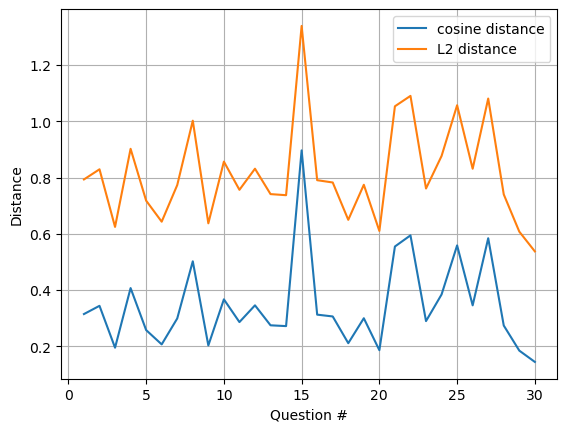

In [ ]:
distance(embedding_Q[:30],embedding_A[:30])

In [ ]:


print(1 - F.cosine_similarity(embedding_Q[np.random.randint(1,250)], embedding_Q[np.random.randint(1,250)],dim=0))
print(torch.norm((embedding_Q[np.random.randint(1,250)] - embedding_Q[np.random.randint(1,250)]),p=2))
print(torch.sum(torch.abs(embedding_Q[np.random.randint(1,250)] - embedding_A[np.random.randint(1,250)])))



tensor(0.8833)
tensor(1.3490)
tensor(19.4674)


In [ ]:
def closest_neighbors(embedding_Q,embedding_A,k): 
    answer_is_near = 0
    embedding = torch.cat([embedding_Q,embedding_A],dim=0)
    for i in range(len(embedding_Q)): 
        distances, indices = torch.topk(-torch.norm(embedding[i] - embedding,dim=1),k)
        if torch.isin(i+len(embedding_Q),indices): 
            answer_is_near += 1
    return answer_is_near/len(embedding_Q)

print(embedding_Q[:50].shape)

print(closest_neighbors(embedding_Q[:50],embedding_A[:50],2))
        


torch.Size([50, 384])
0.76


## Testing the code 

# Ablation

We will now test our code that implements activation patching and ablation. For now, we just test it on random neurons and MLP layers to see whether the fraction of questions containing their answers as nearest neighbors have changed appreciably. 



In [ ]:
ablated_questions = ablate({(3,"attn"): list(range(10))},questions[:50])
ablated_answers = ablate({(3,"MLP"): list(range(10))},answers[:50],list(range(4)))
ablated_questions_2 = ablate({(3,"attn"): list(range(10)),(4,"MLP"): list(range(10))},questions[:50],list(range(2)))
ablated_answers_2 = ablate({(3,"attn"): list(range(10)),(4,"MLP"): list(range(10))},questions[:50])


"""
ablated_questions = ablation([3,4,5],list(range(50,360)),questions[:50],node_type = "attn",type="zero")
ablated_answers = ablation([3,4,5],list(range(50,360)),answers[:50],node_type="attn",type="zero")

print(closest_neighbors(ablated_questions,ablated_answers,2))

"""
print(closest_neighbors(ablated_questions,ablated_answers,2))


0.74


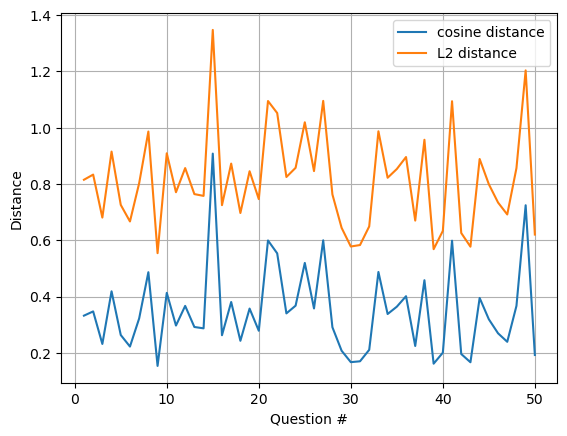

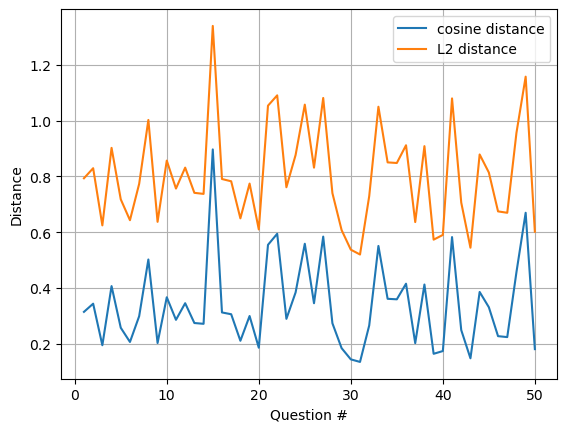

In [ ]:
distance(ablated_questions,ablated_answers)
distance(embedding_Q[:50],embedding_A[:50])



# Activation patching



In [ ]:
orig_prompt = answers[7]
corr_prompt = answers[4]

print(activation_patch(orig_prompt,corr_prompt,{(4,"MLP"): list(range(5)), (2,"attn"): list(range(3))}))



"""
orig_prompt = answers[7]
corr_prompt = answers[4]

max_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))

tokenizers = tokenizer([orig_prompt, corr_prompt],padding='max_length',max_length=max_tokens,truncation=True,return_tensors='pt')

embedding1 = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))
embedding2 = embed(model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors='pt'))

print(F.cosine_similarity(embedding1, embedding2), torch.norm(embedding1 - embedding2, p=2))
print(activation_patching(orig_prompt,corr_prompt,[0,1,2,3],[i for i in range(200)],node_type="MLP"))
print(model.encoder.layer[3]._forward_hooks)
"""

(tensor([[ 1.0803e-02,  5.8160e-02, -7.8230e-02, -7.4246e-03, -6.5818e-02,
          5.4847e-02,  5.1640e-02,  4.7065e-02,  7.3902e-03,  1.1619e-03,
          6.0924e-02, -5.0074e-02,  6.4728e-02, -5.3069e-03, -7.8426e-03,
          1.1993e-02, -3.4348e-02, -1.3903e-02, -1.6738e-01, -3.7977e-03,
          3.9762e-02, -9.9381e-02, -1.0093e-01,  5.2172e-02,  1.2342e-01,
          2.2955e-02, -4.0875e-02, -1.4015e-02,  2.6845e-02,  8.3001e-02,
         -9.1396e-03,  6.9517e-02,  6.7889e-02, -1.7944e-02, -4.3032e-02,
         -1.9585e-02, -9.2464e-02,  1.4787e-03,  3.1826e-02,  1.1767e-02,
         -4.2357e-02,  9.0649e-03, -4.1766e-02, -1.6692e-02, -2.3133e-03,
         -2.3672e-02,  5.0582e-03,  8.0211e-02,  2.8474e-02,  8.2032e-02,
          3.5831e-02,  9.0329e-02, -8.4063e-02,  1.8970e-02,  2.6527e-02,
         -3.4096e-02, -4.9008e-02, -5.5498e-02,  2.3363e-02, -1.0701e-02,
         -1.7745e-02, -4.9218e-03,  1.5386e-02, -1.7568e-02,  5.0498e-02,
         -1.9836e-02, -9.5410e-02,  2

'\norig_prompt = answers[7]\ncorr_prompt = answers[4]\n\nmax_tokens = max(len(tokenizer(orig_prompt)["input_ids"]),len(tokenizer(corr_prompt)["input_ids"]))\n\ntokenizers = tokenizer([orig_prompt, corr_prompt],padding=\'max_length\',max_length=max_tokens,truncation=True,return_tensors=\'pt\')\n\nembedding1 = embed(model,tokenizer(orig_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors=\'pt\'))\nembedding2 = embed(model,tokenizer(corr_prompt, padding = "max_length", max_length = max_tokens, truncation=True, return_tensors=\'pt\'))\n\nprint(F.cosine_similarity(embedding1, embedding2), torch.norm(embedding1 - embedding2, p=2))\nprint(activation_patching(orig_prompt,corr_prompt,[0,1,2,3],[i for i in range(200)],node_type="MLP"))\nprint(model.encoder.layer[3]._forward_hooks)\n'

## Path patching

In [ ]:
sender_node = {(1, "attn"): 2}
receiver_node = {(0, "attn"): 3}

print(path_patching(sender_node,receiver_node,orig_prompt,corr_prompt))

sender_node = {(1, "MLP"): 2}
receiver_node = {(0, "attn"): 3}

print(path_patching(sender_node,receiver_node,orig_prompt,corr_prompt))

sender_node = {(1, "MLP"): 2}
receiver_node = {(0, "MLP"): 3}

#Ablation
print(path_patching(sender_node,receiver_node,orig_prompt,corr_prompt,alpha = 1.5))

#Last layer

print(path_patching(sender_node,clean_prompt = orig_prompt,alpha = 1.5,receiver_is_final_layer = True))



(tensor([[ 1.0803e-02,  5.8160e-02, -7.8230e-02, -7.4246e-03, -6.5818e-02,
          5.4847e-02,  5.1640e-02,  4.7065e-02,  7.3902e-03,  1.1619e-03,
          6.0924e-02, -5.0074e-02,  6.4728e-02, -5.3069e-03, -7.8426e-03,
          1.1993e-02, -3.4348e-02, -1.3903e-02, -1.6738e-01, -3.7977e-03,
          3.9762e-02, -9.9381e-02, -1.0093e-01,  5.2172e-02,  1.2342e-01,
          2.2955e-02, -4.0875e-02, -1.4015e-02,  2.6845e-02,  8.3001e-02,
         -9.1396e-03,  6.9517e-02,  6.7889e-02, -1.7944e-02, -4.3032e-02,
         -1.9585e-02, -9.2464e-02,  1.4787e-03,  3.1826e-02,  1.1767e-02,
         -4.2357e-02,  9.0649e-03, -4.1766e-02, -1.6692e-02, -2.3133e-03,
         -2.3672e-02,  5.0582e-03,  8.0211e-02,  2.8474e-02,  8.2032e-02,
          3.5831e-02,  9.0329e-02, -8.4063e-02,  1.8970e-02,  2.6527e-02,
         -3.4096e-02, -4.9008e-02, -5.5498e-02,  2.3363e-02, -1.0701e-02,
         -1.7745e-02, -4.9218e-03,  1.5386e-02, -1.7568e-02,  5.0498e-02,
         -1.9836e-02, -9.5410e-02,  2

TypeError: path_patching() missing 1 required positional argument: 'receiver_node'

## Identifying which parts of a model are most relevant for relating the answer to the question

There are various ways to attempt to identify how the model encodes meaning into text (such as answers and questions). If we find out how information about semantic meaning flows through the transformer, we can begin to identify relevant circuits within the model. In the case of studying answers and questions, it would be interesting to attempt to identify which parts of the model are most relevant for relating the answer to the question - in other words, how does the relationship between the embedding of the question and answer change as information flows through the model? 

In this section, I attempt to write a function that allows us to plot how the distance between the question and answer embeddings change as we do a forward propagation on the answer. This could potentially be useful for identifying relevant circuits in the future, especially when we combine this analysis with ablation and activation patching. This analysis is inspired by the related concept of "logit lens" in the case of decoder models (see https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=nMCxqqvr7fbM)

In [ ]:
def intermediate_embeddings(text):

    intermediate_act_mlp = []
    intermediate_act_attn = []
    intermediate_embeddings_mlp = []
    intermediate_embeddings_attn = []

    def hook_mlp(module,inp,out): 
        intermediate_act_mlp.append(out)
    def hook_attn(module,inp,out): 
        intermediate_act_attn.append(out)
    for i in range(num_layers): 
        model.encoder.layer[i].output.register_forward_hook(hook_mlp)     #mlp.layernorm
        model.encoder.layer[i].attention.output.register_forward_hook(hook_attn)     #attention.output
    text_embedding = embed(model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    intermediate_embeddings_mlp = torch.stack([F.normalize(mean_pooling(intermediate_act_mlp[i],tokenizer(text, padding = True, truncation=True, return_tensors='pt')["attention_mask"]), p=2,dim=1) for i in range(num_layers)])
    intermediate_embeddings_attn = torch.stack([F.normalize(mean_pooling(intermediate_act_attn[i],tokenizer(text, padding = True, truncation=True, return_tensors='pt')["attention_mask"]), p=2,dim=1) for i in range(num_layers)])

    return intermediate_embeddings_mlp, intermediate_embeddings_attn

intermediate_embeddings_mlp, intermediate_embeddings_attn = intermediate_embeddings("hallo")
print(model(**tokenizer(questions[:5], padding = True, truncation=True, return_tensors='pt'))[0].shape)
print(intermediate_embeddings_mlp.shape)
print(intermediate_embeddings_attn.shape)
print(embed(model,tokenizer("hallo", padding = True, truncation=True, return_tensors='pt')).shape)

torch.Size([5, 84, 384])
torch.Size([6, 1, 384])
torch.Size([6, 1, 384])
torch.Size([1, 384])


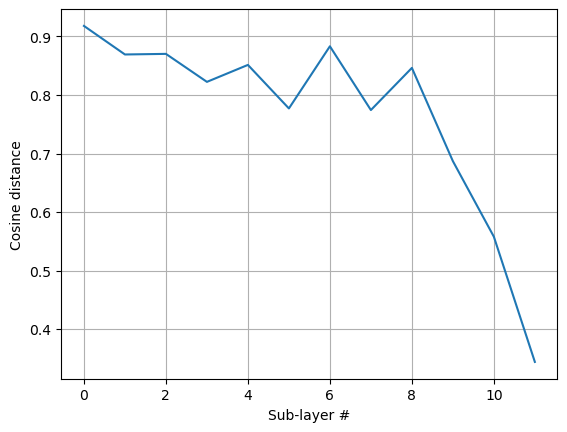

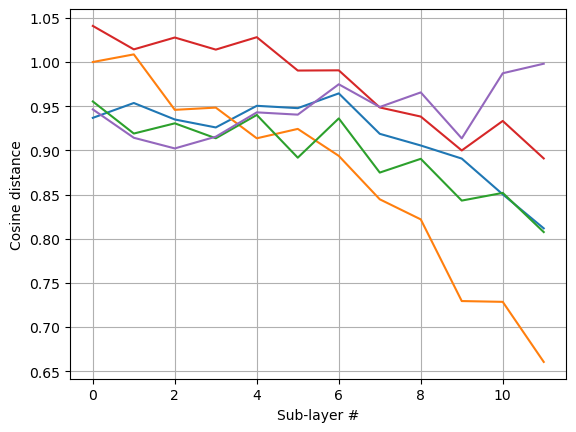

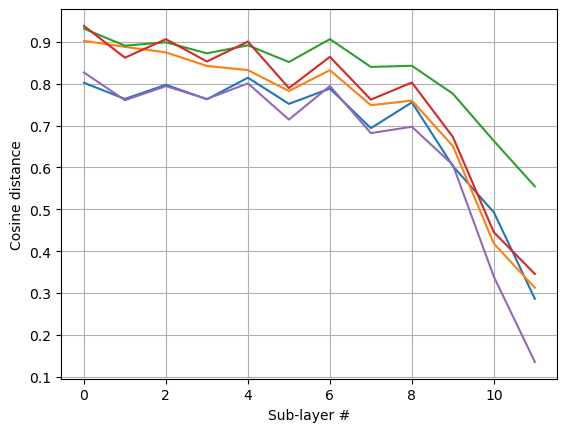

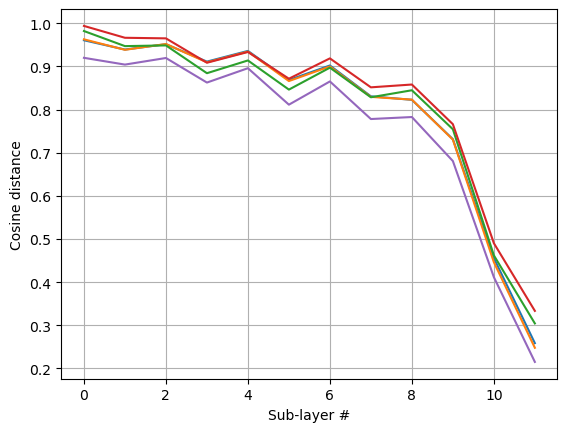

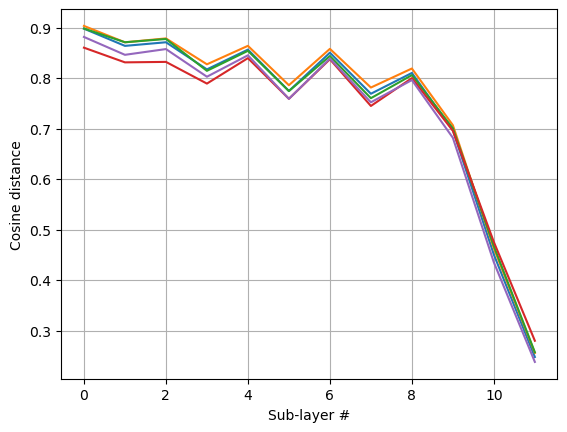

In [ ]:
def embedding_distance(reference_embedding,text): 
        #reference_embedding = embed(reference_text,model,tokenizer(reference_text, padding = True, truncation=True, return_tensors='pt'))

    if len(reference_embedding) != len(text): 
        raise ValueError("The number of reference embedding vectors and text prompts must be equal for a proper comparison! ")
    for i in range(len(reference_embedding)): 
        intermediate_embeddings_mlp,intermediate_embeddings_attn = intermediate_embeddings(text[i])
        distances_mlp = 1 - F.cosine_similarity(reference_embedding[i],intermediate_embeddings_mlp,dim=2)                               #torch.norm(reference_embedding - intermediate_embeddings_mlp,dim=2)
        distances_attn = 1 - F.cosine_similarity(reference_embedding[i],intermediate_embeddings_attn,dim=2)                                #torch.norm(reference_embedding - intermediate_embeddings_attn,dim=2)

        distances = []

        for j in range(len(intermediate_embeddings_mlp)): 
            distances.append(distances_attn[j])
            distances.append(distances_mlp[j])

        plt.plot(list(range(2*num_layers)),distances)
        plt.xlabel("Sub-layer #")
        plt.ylabel("Cosine distance")
        plt.grid()
    plt.show()

answer_embeddings = []
unequal_questions = []
equal_questions = []

for i in range(5): 
    answer_embeddings.append(embed(model,tokenizer(answers[10 + 5*i], padding = True, truncation=True, return_tensors='pt')))
    unequal_questions.append(questions[11 + 5*i])
    equal_questions.append(questions[10 + 5*i])

embedding_distance([embed(model,tokenizer(answers[1], padding = True, truncation=True, return_tensors='pt'))],[questions[1]])

embedding_distance(answer_embeddings,unequal_questions)
embedding_distance(answer_embeddings,equal_questions)


physics_answer_embeddings = []
equal_physics_question = []
for i in range(4): 
    physics_answer_embeddings.append(embed(model,tokenizer(wrong_physics_answers[f"{i}.0"], padding = True, truncation=True, return_tensors='pt')))
    equal_physics_question.append(physics_questions[0])

physics_answer_embeddings.append(embed(model,tokenizer(physics_answers[0], padding = True, truncation=True, return_tensors='pt')))
equal_physics_question.append(physics_questions[0])

embedding_distance(physics_answer_embeddings,equal_physics_question)


physics_answer_embeddings = []
equal_physics_question = []
for i in range(4): 
    physics_answer_embeddings.append(embed(model,tokenizer(wrong_physics_answers[f"{i}.1"], padding = True, truncation=True, return_tensors='pt')))
    equal_physics_question.append(physics_questions[1])

physics_answer_embeddings.append(embed(model,tokenizer(physics_answers[1], padding = True, truncation=True, return_tensors='pt')))
equal_physics_question.append(physics_questions[1])

embedding_distance(physics_answer_embeddings,equal_physics_question)

## Finding the most important activations

In order to know which features are most important for the circuits, we need to visualize the activations within the model. That is what we will implement now. 

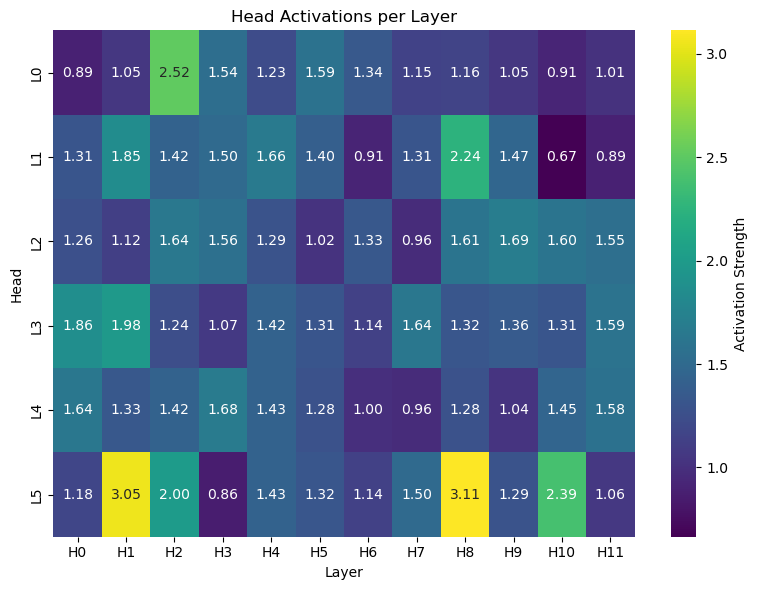

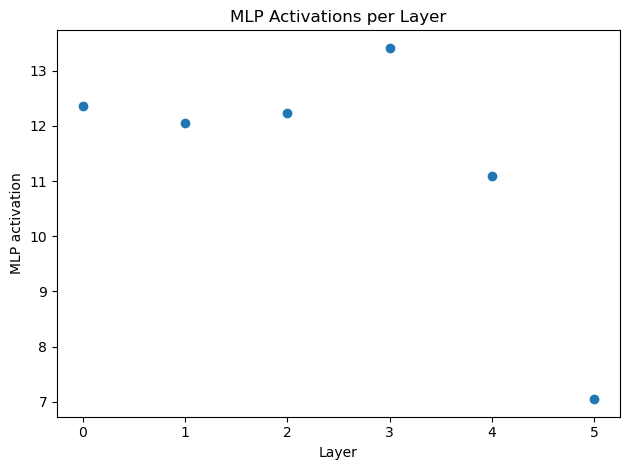

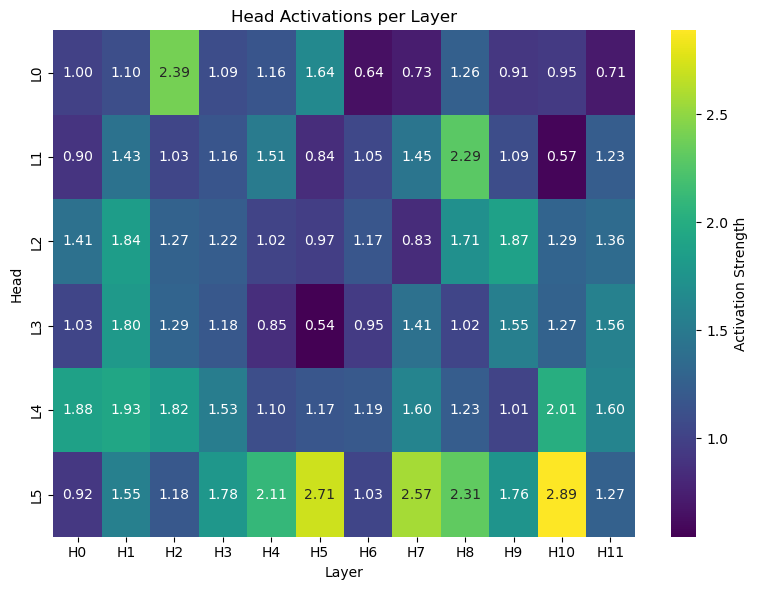

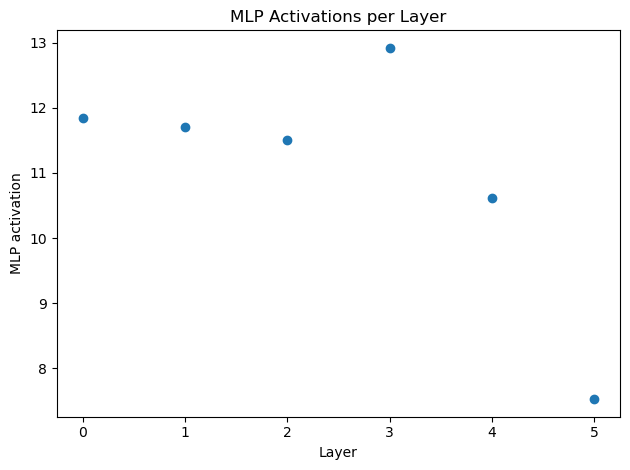

In [ ]:
import math
import seaborn as sns

def activations(text): 

    def patch_attention_heads(model, layer_idx):
        attn = model.encoder.layer[layer_idx].attention.self
        attn.original_forward = attn.forward

        def forward(self, hidden_states, *args, **kwargs):
            mixed_query_layer = self.query(hidden_states)
            mixed_key_layer = self.key(hidden_states)
            mixed_value_layer = self.value(hidden_states)

            query_layer = self.transpose_for_scores(mixed_query_layer)
            key_layer = self.transpose_for_scores(mixed_key_layer)
            value_layer = self.transpose_for_scores(mixed_value_layer)

            # Take the dot product between "query" and "key" to get the raw attention scores.
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
            attention_scores = attention_scores/math.sqrt(self.attention_head_size)

            # Normalize the attention scores to probabilities.
            attention_probs = F.softmax(attention_scores,dim=-1)

            # This is actually dropping out entire tokens to attend to, which might
            # seem a bit unusual, but is taken from the original Transformer paper.
            attention_probs = self.dropout(attention_probs)

            context_layer = torch.matmul(attention_probs, value_layer)
            self.per_head_output = context_layer.detach()   # shape: (batch_size, attention_head, seq_len, attn_dim)

            context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
            new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
            context_layer = context_layer.view(*new_context_layer_shape)

            outputs = (context_layer, attention_probs)
            return outputs
        attn.forward = MethodType(forward, attn)

    mlp_output = []
    handles = []
    def hook_mlp(module, inp, out): 
        mlp_output.append(out)
    for i in range(num_layers): 
        patch_attention_heads(model, i)
        handles.append(model.encoder.layer[i].output.register_forward_hook(hook_mlp))
    embed(model,tokenizer(text, padding = True, truncation=True, return_tensors='pt'))
    attention_head_act = np.array([torch.norm((model.encoder.layer[i].attention.self.per_head_output), p = 2,dim=-1).mean(dim=[0,2]) for i in range(num_layers)])
    mlp_act = np.array([torch.norm((mlp_output[i]), p = 2,dim=-1).mean(dim=[0,1]) for i in range(num_layers)])
    for i in range(num_layers): 
        handles[i].remove()
        model.encoder.layer[i].attention.self.forward = model.encoder.layer[i].attention.self.original_forward
    
    #Plotting attention head activations for every layer
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_head_act, cmap='viridis', annot=True, fmt=".2f", 
            xticklabels=[f"H{i}" for i in range(attention_head_act.shape[1])],
            yticklabels=[f"L{i}" for i in range(attention_head_act.shape[0])],
            cbar_kws={"label": "Activation Strength"})
    plt.title("Head Activations per Layer")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    plt.plot(range(num_layers),mlp_act,"o")
    plt.title("MLP Activations per Layer")
    plt.xlabel("Layer")
    plt.ylabel("MLP activation")
    plt.tight_layout()
    plt.show()

activations(answers[1])
activations(physics_answers[1])
